# Tutorial for the deconvolution of hydrophone measurement data

Martin Weber, Volker Wilkens, Sascha Eichstädt

Physikalisch-Technische Bundesanstalt, Ultrasonics Working Group

## 1. Introduction
This tutorial presents and explains examples of the deconvolution of hydrophone measurement data. The motivation for performing deconvolution is that, in many cases, measurements of ultrasonic signals are performed with a hydrophone that is (more or less) far from being perfect. The characteristic addressed by deconvolution is the frequency response of the hydrophone, which, in general, is different from an ideal flat characteristic [[Wilkens2004](#literature), [Wear2014](#literature)]. Mathematically speaking, the measured signal voltage (expressed in the time domain) of the hydrophone is the convolution of the acoustic pulse waveform and of the hydrophone impulse response [[Cooling2008](#literature), [Hurrell2016](#literature)]. The hydrophone sensitivity can be determined by calibration. In recent years, calibration methods have been improved and extended and provide now the possibility of obtaining amplitude and phase data in a broad frequency range and with a high number of sampling frequencies [[Weber2017](#literature), [Wilkens2019](#literature)]. For deconvolution, it is required that the sensitivity as a complex quantity (usually noted as a real and as an imaginary value or amplitude / modulus and phase value) is available. If experimental phase data is not available, phase responses may be calculated from modulus data assuming minimum phase system behavior. Determination of the uncertainty may be less straightforward when deconvolution is applied [[Eichstaedt2016a](#literature)] – in comparison to the usage of a single hydrophone sensitivity factor (scaling). It is therefore particularly addressed within this tutorial. 

This tutorial uses a set of hydrophone calibration data and hydrophone measurement data as examples. The data sets and the results obtained by deconvolution are made publicly available through a repository to serve as reference data sets. The data sets can be applied to validate other deconvolution implementations by users.


The overall process is shown in the following diagram:
<img src="Diagram.svg" />


## 2. Preparation
This tutorial is written as a Jupyter notebook and uses Python 3. The [Anaconda software package](https://www.anaconda.com/distribution/) was used, as it makes it easy to install Python and Jupyter. Furthermore,
this notebook uses the GUM2DFT implementation included in the [[PyDynamics](#literature)] package provided by Sascha Eichstädt [[Eichstaedt2016b](#literature)] in Version 1.4.3 (downloaded on 26.08.2020). The latest version of this package can be installed by typing `pip install PyDynamic` into the command line. The latest information about the software version can be found online at the [[Git repository](https://github.com/eichstaedtPTB/PyDynamic), [DOI](https://doi.org/10.5281/zenodo.3906568)] . If it is not possible to install the software from the online source, the software package can be downloaded and installed by typing the command `pip install` *`filepath`*. A snapshot of the PyDynamic package which was originally used for the calculation is provided together with this tutorial. It can be found in the main folder and is installed in the same manner. It was used to test this notebook.

To reset all data from the interpreter, all variables are cleared with the following statement:

In [1377]:
%reset -f
#Reset all variables

Python and Jupyter allow different methods to draw diagrams. They can be inserted into the notebook (`%matplotlib notebook`) as interactive objects or as static pictures (`%matplotlib inline`), or they can be drawn in a separate window (`%matplotlib qt5`). After changing the plotting method, a restart of the kernel is necessary.

In [1378]:
#next line enables the interactive plots in this notebook: (comment line till the end in order to deactivate the command)
#%matplotlib notebook
#next line enables the static plots in this notebook:
%matplotlib inline
#uncomment next line for interactive plots in a separate window: (Note that automatic running will put all graphics in one diagram)
#%matplotlib qt5
#other possible variants can be found by %matplotlib --list

All necessary libraries are imported.

In [1379]:
import numpy as np
import PyDynamic
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import sympy as sym #symbolic calculation (integration)    

#### Links to quickly jump to cells
These links provide quick access to those cells that are often modified for comparison calculations:
* [Choose file](#ChooseFile)
* [Choose frequency range of calibration data](#FreqRange)
* [Choose calculation of phase from amplitude by Bode equation](#bode)
* [Set filter frequency and type of filter](#RegFilter)

### 2.1. Definition of Functions
For the calculation, some helper functions are defined.
#### 2.1.1. Function for calculating the frequency from the time series
This function uses the information of a time series and calculates the corresponding frequencies. It is used to create the frequency scales in accordance with the time series.

In [1380]:
def calcfreqscale(timeseries,sign2 = 1):
    """Calculates the appropriate time scale for a given (equidistant) time series
    TODO: Add case for Complex GUM_DFT
    
    Parameters
    ----------
        timeseries: ndarray
            strictly increasing and equidistant steps of the sampling time, max- and min-value is used for calculation
        sign2: integer (optional)
            sign for sin part frequencies, allows to be negative for plotting
            1 gives positive frequencies fitting to GUM_DFT data (default)
            0 gives only first half
            -1 sin part is negative, usable for easy plotting
            
        
    Returns
    -------
        f: ndarray
            frequencies matching the result of GUM_DFT if sign2 has the default value of 1
    
    """
    n = np.size(timeseries)
    if sign2 < 0:
        sign = -1
    else:
        sign = 1
    
    fmax = 1/((np.max(timeseries)-np.min(timeseries))*n/(n-1))*(n-1)
    
    f = np.linspace(0,fmax,n)
    
    f2 = np.hstack((f[0:int(n/2.+1)],sign*f[0:int(n/2+1)]))
    if sign2 == 0:
        f2 = f[0:int(n/2.+1)]
    
    return f2

In [1381]:
# Test of the function
t = [0,1,2,3,4,5,6,7,8,9] #s (10 seconds sampled at 1 Hz)
# this should yield a frequency scale with 0.1 Hz resolution and 1 Hz / 2 = 0.5 Hz maximum frequency
calcfreqscale(t,1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0. , 0.1, 0.2, 0.3, 0.4, 0.5])

#### 2.1.2 Functions to convert PyDynamic-style vectors
These functions are used to convert the complex data vectors created by the PyDynamic library into other formats. They are defined for amplitude, phase, real part and imaginary part.

In [1382]:
# Return the amplitude of a PyDynamic-style vector
def Amplitude(data):
    n = data.size
    return np.sqrt(data[:int(n/2)]**2+data[int(n/2):]**2)

# Return the phase (in rad) of a PyDynamic-style vector
def Phase(data):
    n = data.size
    return np.arctan2(data[int(n/2):],data[:int(n/2)])

# Return the real part of a PyDynamic-style vector
def Realpart(data):
    n = data.size
    return data[:int(n/2)]

# Return the imaginary part of a PyDynamic-style vector
def Imagpart(data):
    n = data.size
    return data[int(n/2):]

#### 2.1.3 Function to calculate pulse parameters

This function is used to calculate the pulse parameters of a time sequence. It calculates the peak-compressional pressure ($p_c$) and the peak-rarefactional pressure ($p_r$) together with the uncertainty. Furthermore, the time and the index of the peak pressure are given as a result.

The pulse-pressure-squared integral (ppsi) is calculated as $ppsi=\sum_i p_i^2 \Delta t$. The uncertainty calculation is given as follows:

$\frac{\partial ppsi}{\partial p_i}=2 p_i \Delta t$

$u_{ppsi}= \sqrt{\sum_i \left( \frac{\partial ppsi}{\partial p_i} \right)^2 u_{p_i}^2 }=
\sqrt{\sum_i (2 p_i \Delta t)^2 u_{p_i}^2 }
$

#### 2.1.4 Function to calculate pulse parameters considering correlation

This function is used to calculate the pulse parameters of a time sequence. It calulates the peak-compressional pressure ($p_c$) and the peak-rarefactional pressure ($p_r$) together with the uncertainty. Furrthermore, the time and the index of the peak pressure are given as a result.

The pulse-pressure-squared integral (ppsi) is calculated as $ppsi=\sum_{i=1}^n p_i^2 \Delta t$. The correlation must be considered [PTB2014](#Literature). This is done by taking the covariance matrix $U_p$ into account. The uncertainty calculation is given as follows:

${p_i}^{\prime} = |p_i|$

$c_i=\frac{\partial ppsi}{\partial p_i}=2 {p_i}^{\prime} \Delta t$

$C = [c_1, \dots, c_n]$

$u_{ppsi}^2 = C \cdot U_p \cdot C^T $

<!--- $u_{ppsi}^2= {\sum_{i=1}^N c_i^2 u_{p_i}^2 } + 2 \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} c_i c_j u_{p_i} u_{p_j} r
$ -->

In [1383]:
def pulseparameter(time,pressure,u_pressure):
    """Calculates the pulse parameter of a given time series
    
    Parameters
    ----------
        time: ndarray
            strictly increasing and equidistant steps of the sampling time, max- and min-value is used for calculation
            size must be 1,n
        pressure: ndarray
            time series of pressure data
            of size 1,n
        u_pressure: ndarray
            uncertainty of pressure data.
            Possible variants are uncertainty (1,1) float: same uncertainty [sqrt(variance)] in all time steps
            Uncertainty as vector (1,n) ndarray: individual uncertainty [sqrt(variance)] in all time steps
            Covariance matrix (n,n) ndarray: full covariance matrix [variance] is used.
            
        All data sets must match in length and size
            
        
    Returns
    -------
        result: dict
            returns the calculated pulse parameters
            pc: peak compression pressure
            pr: peak rarefaction pressure
            ppsi: pulse-pressure-squared integral
            _index: index of peak location in list
            _value: value of the parameter
            _uncertainty: uncertainty of the parameter
            _time: position of peak on time scale
            
    
    """
    
    assert len(time) == len(pressure),"Lengths of data sets do not match."
    
    if len(np.shape(u_pressure)) == 0:
        u_pressure = np.ones_like(pressure) * u_pressure #if a single number is given, build an uncertainty vector
    if len(np.shape(u_pressure)) == 1:
        u_pressure = np.diag(u_pressure**2.) #if an uncertainty vector is given, build an covariance matrix
    
    assert np.shape(u_pressure)[0] == len(pressure), "(First) dimension of u_pressure does not match"
    assert np.shape(u_pressure)[1] == len(pressure), "(Second) dimension of u_pressure does not match"
    
    dt = (max(time)-min(time))/(len(time)-1)
    result = {"dt":dt}
    pc_index = np.argmax(pressure)
    result["pc_index"] = pc_index
    result["pc_value"] = pressure[pc_index]
    result["pc_uncertainty"] = np.sqrt(u_pressure[pc_index,pc_index])
    result["pc_time"] = time[pc_index]
    
    pr_index = np.argmin(pressure)
    result["pr_index"] = pr_index
    result["pr_value"] = -pressure[pr_index]
    result["pr_uncertainty"] = np.sqrt(u_pressure[pr_index,pr_index])
    result["pr_time"] = time[pr_index]
    
    result["ppsi_value"] = np.sum(np.square(pressure))*dt
    #calculation of the sensitivity matrix
    C = 2*np.abs(pressure)*dt
    var = np.dot(C,np.dot(u_pressure,np.transpose(C))) #calculate the covariance matrix C*u_pressure*C^(T)
    
    result["ppsi_uncertainty"] = np.sqrt(var)
    return result

### 2.2. Hydrophones
For this tutorial, four hydrophones of different types, all with small active elements, are used to investigate the deconvolution procedures with the lowest possible impact of the spatial averaging effect.
#### 2.2.1 Gampt MH44
Membrane hydrophone with a foil thickness of 11 µm and a high-frequency effective diameter of 0.14 mm. The effective diameter was determined by investigating the directional response at several frequencies. The value stated is the asymptotic value at high frequencies. The calibration data was determined in the frequency range from 0.1 MHz to 100 MHz by means of primary calibration [[Weber2017](#literature)].
#### 2.2.2. Gampt MH46
Membrane hydrophone with a polyurethane backing. The foil thickness is 4.5 µm and the effective diameter is 0.12 mm. The effective diameter was determined by investigating the directional response at several frequencies. The value stated is the asymptotic value at high frequencies. The calibration data was determined in the frequency range from 0.1 MHz to 100 MHz by means of primary calibration [[Weber2017](#literature)].
#### 2.2.3. ONDA SN 1704
Capsule-type hydrophone with a nominal diameter of 0.085 mm. The effective diameter is 0.14 mm as determined by investigating the directional response at several frequencies. The value stated is the asymptotic value at high frequencies. The calibation data was determined in the frequency range from 0.1 MHz to 100 MHz by means of secondary calibration. Thereby, the Gampt MH46 hydrophone was used as a reference [[Wilkens2019](#literature)].
#### 2.2.4 Precision Acoustics SN 1434
Needle-type hydrophone with a nominal diameter of 0.075 mm. The effective diameter is 0.11 mm as determined by investigating the directional response at several frequencies. The value stated is the asymptotic value at high frequencies. The calibration data were determined in the frequency range from 0.1 MHz to 100 MHz by means of primary calibration [[Weber2017](#literature)].
### 2.3. Signals
For this tutorial, ultrasonic signals of an ultrasonic diagnostic device (Siemens Sonoline Sienna) were measured by each of the afore-mentioned hydrophones. The device was used in two different modes. The first mode used was the motion (M) mode which produces waveforms that are similar to the common brightness (B) mode, but without scanning the ultrasonic beam. This mode uses a short pulse with only a few cycles. The other mode was the pulse Doppler (pD) mode which is used to investigate the flow of liquids. For the Doppler mode, a burst signal with several cycles is produced. Both modes were operated at two different frequencies. The signals at the lower acoustic work frequency were emitted from a convex array (C5-2), and the signals at the higher acoustic work frequency from a linear array (7.5L40). Settings were chosen for the acoustic work frequency, the output power, the focal length, the region of interest and the pulse repetition frequency. These parameters produce the maximum spatial-peak temporal-average intensity of the diagnostic machine with the respective transducer for the particular mode. The waveforms were acquired at the position of the spatial-peak temporal-average intensity. The different combinations that were investigated can be found in the following table.
### 2.4 Selecting a data set <a id="ChooseFile"></a>

By choosing the values for `i`, the different data sets can be selected.

|Number (i)|Mode|Frequency|Hydrophone|
|------|----|---------|----------|
|1|M|3 MHz|GAMPT MH44|
|2|M|3 MHz|GAMPT MH46|
|3|M|3 MHz|ONDA 1704|
|4|M|3 MHz|Precision Acoustics 1434|
|5|pD|3 MHz|GAMPT MH44|
|6|pD|3 MHz|GAMPT MH46|
|7|pD|3 MHz|ONDA 1704|
|8|pD|3 MHz|Precision Acoustics 1434|
|9|M|6 MHz|GAMPT MH44|
|10|M|6 MHz|GAMPT MH46|
|11|M|6 MHz|ONDA 1704|
|12|M|6 MHz|Precision Acoustics 1434|
|13|pD|7 MHz|GAMPT MH44|
|14|pD|7 MHz|GAMPT MH46|
|15|pD|7 MHz|ONDA 1704|
|16|pD|7 MHz|Precision Acoustics 1434|

`M`: motion mode
`pD`: pulse Doppler mode

In [1384]:
i = 1# i can have a value between 1 and 16
infos = {"i":i}

In [1385]:
infos["resultpathname"] = "Results/" #path for saving data

In [1386]:
#M mode 3 MHz
if i==1:
    measurementfile = "MeasuredSignals/M-Mode 3 MHz/M3_MH44.DAT"
    noisefile = "MeasuredSignals/M-Mode 3 MHz/M3_MH44r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_MH44ReIm.csv"
    infos["hydrophonename"] = "GAMPT MH44"
    infos["measurementtype"] = "M-Mode 3 MHz"
    measurement_data = {}

if i==2:
    measurementfile = "MeasuredSignals/M-Mode 3 MHz/M3_MH46.DAT"
    noisefile = "MeasuredSignals/M-Mode 3 MHz/M3_MH46r.DAT"
    hydfilename = "HydrophoneCalibrationData/MH46_MWReIm.csv"
    infos["hydrophonename"] = "GAMPT MH46"
    infos["measurementtype"] = "M-Mode 3 MHz"
    measurement_data = {}

if i==3:
    measurementfile = "MeasuredSignals/M-Mode 3 MHz/M3_ON1704.DAT"
    noisefile = "MeasuredSignals/M-Mode 3 MHz/M3_ON1704r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_ONDA1704_SECReIm.csv"
    infos["hydrophonename"] = "ONDA1704"
    infos["measurementtype"] = "M-Mode 3 MHz"
    measurement_data = {}

if i==4:
    measurementfile = "MeasuredSignals/M-Mode 3 MHz/M3_PA1434.DAT"
    noisefile = "MeasuredSignals/M-Mode 3 MHz/M3_PA1434r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_PA1434ReIm.csv"
    infos["hydrophonename"] = "Precision Acoustics 1434"
    infos["measurementtype"] = "M-Mode 3 MHz"
    measurement_data = {}

### pD3-Mode 3 MHz

if i==5:
    measurementfile = "MeasuredSignals/pD-Mode 3 MHz/pD3_MH44.DAT"
    noisefile = "MeasuredSignals/pD-Mode 3 MHz/pD3_MH44r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_MH44ReIm.csv"
    infos["hydrophonename"] = "GAMPT MH44"
    infos["measurementtype"] = "Pulse-Doppler-Mode 3 MHz"
    measurement_data = {}

if i==6:
    measurementfile = "MeasuredSignals/pD-Mode 3 MHz/pD3_MH46.DAT"
    noisefile = "MeasuredSignals/pD-Mode 3 MHz/pD3_MH46r.DAT"
    hydfilename = "HydrophoneCalibrationData/MH46_MWReIm.csv"
    infos["hydrophonename"] = "GAMPT MH46"
    infos["measurementtype"] = "Pulse-Doppler-Mode 3 MHz"
    measurement_data = {}

if i==7:
    measurementfile = "MeasuredSignals/pD-Mode 3 MHz/pD3_ON1704.DAT"
    noisefile = "MeasuredSignals/pD-Mode 3 MHz/pD3_ON1704r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_ONDA1704_SECReIm.csv"
    infos["hydrophonename"] = "ONDA1704"
    infos["measurementtype"] = "Pulse-Doppler-Mode 3 MHz"
    measurement_data = {}

if i==8:
    measurementfile = "MeasuredSignals/pD-Mode 3 MHz/pD3_PA1434.DAT"
    noisefile = "MeasuredSignals/pD-Mode 3 MHz/pD3_PA1434r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_PA1434ReIm.csv"
    infos["hydrophonename"] = "Precision Acoustics 1434"
    infos["measurementtype"] = "Pulse-Doppler-Mode 3 MHz"
    measurement_data = {}

#M mode 6 MHz
if i==9:
    measurementfile = "MeasuredSignals/M-Mode 6 MHz/M6_MH44.DAT"
    noisefile = "MeasuredSignals/M-Mode 6 MHz/M6_MH44r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_MH44ReIm.csv"
    infos["hydrophonename"] = "GAMPT MH44"
    infos["measurementtype"] = "M-Mode 6 MHz"
    measurement_data = {}

if i==10:
    measurementfile = "MeasuredSignals/M-Mode 6 MHz/M6_MH46.DAT"
    noisefile = "MeasuredSignals/M-Mode 6 MHz/M6_MH46r.DAT"
    hydfilename = "HydrophoneCalibrationData/MH46_MWReIm.csv"
    infos["hydrophonename"] = "GAMPT MH46"
    infos["measurementtype"] = "M-Mode 6 MHz"
    measurement_data = {}

if i==11:
    measurementfile = "MeasuredSignals/M-Mode 6 MHz/M6_ON1704.DAT"
    noisefile = "MeasuredSignals/M-Mode 6 MHz/M6_ON1704r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_ONDA1704_SECReIm.csv"
    infos["hydrophonename"] = "ONDA1704"
    infos["measurementtype"] = "M-Mode 6 MHz"
    measurement_data = {}

if i==12:
    measurementfile = "MeasuredSignals/M-Mode 6 MHz/M6_PA1434.DAT"
    noisefile = "MeasuredSignals/M-Mode 6 MHz/M6_PA1434r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_PA1434ReIm.csv"
    infos["hydrophonename"] = "Precision Acoustics 1434"
    infos["measurementtype"] = "M-Mode 6 MHz"
    measurement_data = {}

    
#pD mode 7 MHz
if i==13:
    measurementfile = "MeasuredSignals/pD-Mode 7 MHz/pD7_MH44.DAT"
    noisefile = "MeasuredSignals/pD-Mode 7 MHz/pD7_MH44r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_MH44ReIm.csv"
    infos["hydrophonename"] = "GAMPT MH44"
    infos["measurementtype"] = "Pulse-Doppler-Mode 7 MHz"
    measurement_data = {}

if i==14:
    measurementfile = "MeasuredSignals/pD-Mode 7 MHz/pD7_MH46.DAT"
    noisefile = "MeasuredSignals/pD-Mode 7 MHz/pD7_MH46r.DAT"
    hydfilename = "HydrophoneCalibrationData/MH46_MWReIm.csv"
    infos["hydrophonename"] = "GAMPT MH46"
    infos["measurementtype"] = "Pulse-Doppler-Mode 7 MHz"
    measurement_data = {}

if i==15:
    measurementfile = "MeasuredSignals/pD-Mode 7 MHz/pD7_ON1704.DAT"
    noisefile = "MeasuredSignals/pD-Mode 7 MHz/pD7_ON1704r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_ONDA1704_SECReIm.csv"
    infos["hydrophonename"] = "ONDA1704"
    infos["measurementtype"] = "Pulse-Doppler-Mode 7 MHz"
    measurement_data = {}

if i==16:
    measurementfile = "MeasuredSignals/pD-Mode 7 MHz/pD7_PA1434.DAT"
    noisefile = "MeasuredSignals/pD-Mode 7 MHz/pD7_PA1434r.DAT"
    hydfilename = "HydrophoneCalibrationData/MW_PA1434ReIm.csv"
    infos["hydrophonename"] = "Precision Acoustics 1434"
    infos["measurementtype"] = "Pulse-Doppler-Mode 7 MHz"
    measurement_data = {}
    
print("i={1}: File \"{0}\" loaded.".format(measurementfile,i))
print("Hydrophone: {0}\nMeasurement: {1}\nPath: {2}".format(infos["hydrophonename"],infos["measurementtype"],infos["resultpathname"]))

i=11: File "MeasuredSignals/M-Mode 6 MHz/M6_ON1704.DAT" loaded.
Hydrophone: ONDA1704
Measurement: M-Mode 6 MHz
Path: Results/


### 2.5. Preprocessing of the measurement data
In the first step, the measurement data of the hydrophone voltage is imported into the program. For simplicity, the voltage data is assumed to be in a file containing 1 column of data points. The voltage is given in volts. The information about the time steps can be found in a header file which is read as well. The time information is given in seconds. Equidistant time data is used for this tutorial. In case the sample points are not equidistant, the PyDynamic help function `make equidistant` can be used.

The data format in the file is a single column list with values. The first row gives the number of data points. The second row gives the time increment between successive measurement points in seconds. The 3rd row and the 4th row can be ignored. In row 5 up to the end, the measured voltage is given.

In [1387]:
measurement_data = {"name":measurementfile} #store information in dict
rawdata = np.loadtxt(measurementfile)
measurement_data["voltage"] = rawdata[4:] #read data as list
measurement_data["voltage"] = measurement_data["voltage"] - np.mean(measurement_data["voltage"]) # remove any DC component 
print("The file {0} was read and it contains {1} data points.".format(measurement_data["name"],measurement_data["voltage"].size)) #Give some details
measurement_data["time"] = np.array(range(0,int(rawdata[0])))*rawdata[1] #build time scale from header information
print("The time increment is {0} s.".format(measurement_data["time"][1]))

The file MeasuredSignals/M-Mode 6 MHz/M6_ON1704.DAT was read and it contains 2500 data points.
The time increment is 2e-09 s.


After reading the data, two vectors are available. The vector `measurement_data["time"]` contains information about the time steps, and the vector `measurement_data["voltage"]` contains the voltage level at each time step.

#### 2.5.1. _Optional:_ Uncertainty estimation of the measurement data
To each data point of the measurement, an uncertainty should be assigned. In a simple (but typical) case, the uncertainty can be estimated for each point by means of the quantization uncertainty of the instrument as an upper bound. Furthermore, the additional contribution of a possible scaling error should be taken into account. In this example, the quantization error is assumed to have a rectangular distribution. It is calculated by means of the full range of measurement and by the number of bits of the AD converter $2 \Delta a = \frac{U_{full range}}{2^n}$. This distribution can be transferred into a standard deviation $2 \Delta a$: $u_x = \frac{\Delta a}{ \sqrt{3}}$ that will be used in later uncertainty calculations. For other distributions, the value needs to be corrected. The conversion factors can be found in the literature [[GUM2008](#literature)].

The uncertainty vector is calculated from this value. If more information is known about the uncertainty at each time step – derived, for instance, from a separate voltage calibration measurement of the oscilloscope, then this vector can be altered and all the information should be used for further calculation.

#### 2.5.2. Uncertainty calculated from noise data
The preferred way is to determine the uncertainty experimentally. The hydrophone is connected to the oscilloscope (as in the waveform measurements). The oscilloscope has the same settings (voltage resolution, sample rate, number of averages and so on) as during the aquisition of the waveform. But this time, no ultrasonic signal is transmitted, so that only the noise of the hydrophone (together with the noise ot the oscilloscope) is present. From this data, the standard deviation from the mean value (voltage offset) can be calculated and be used as the uncertainty of the signal voltages.

In [1388]:
noise_data = {"name":noisefile} #store information in dict
noise_data["voltage"] = np.loadtxt(noisefile)[4:] #read data as list
print("The file \"{0}\" was read and it contains {1} data points.".format(noise_data["name"],noise_data["voltage"].size)) #Give some details

The file "MeasuredSignals/M-Mode 6 MHz/M6_ON1704r.DAT" was read and it contains 2500 data points.


In [1389]:
#Calculate mean and stddiv
mean = np.mean(noise_data["voltage"])
stdev = np.std(noise_data["voltage"])

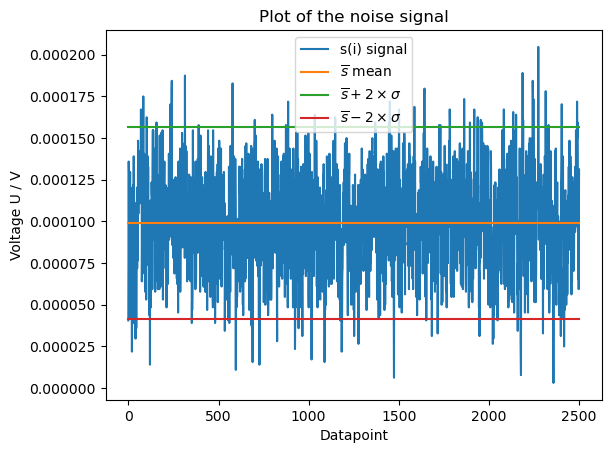

In [1390]:
plt.plot(noise_data["voltage"] )
plt.plot([0,len(noise_data["voltage"])],[mean,mean])
plt.plot([0,len(noise_data["voltage"])],[mean+2*stdev,mean+2*stdev])
plt.plot([0,len(noise_data["voltage"])],[mean-2*stdev,mean-2*stdev])
plt.title("Plot of the noise signal")
plt.xlabel("Datapoint")
plt.ylabel("Voltage U / V")
plt.legend(["s(i) signal",r'$\overline{s}$ mean',r'$\overline{s}+2\times\sigma$',r'$\overline{s}-2\times\sigma$'])

In [1391]:
#add uncertainty information to data
uncertainty = np.ones(np.shape(measurement_data["voltage"]))*stdev
print("Elements in vector: ",len(uncertainty))
measurement_data["uncertainty"] = uncertainty #Add information for uncertainty

Elements in vector:  2500


#### 2.5.3. Plot of the measurement data
All data of the measurement and the assigned uncertainty are plotted. The standard uncertainty is multiplied by the coverage factor  k = 2.

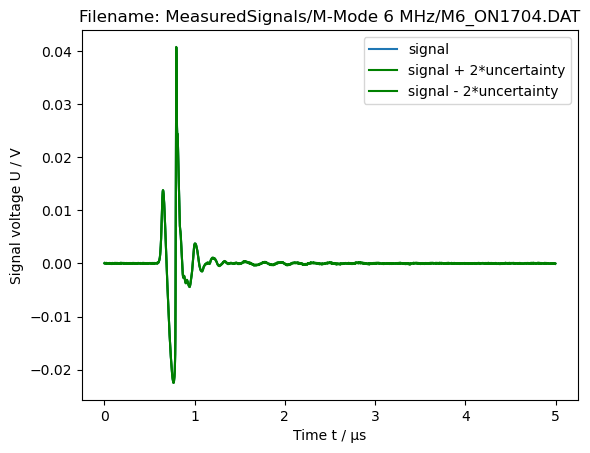

In [1392]:
plt.plot(measurement_data["time"]/1e-6,measurement_data["voltage"])
plt.plot(measurement_data["time"]/1e-6,measurement_data["voltage"]+2*measurement_data["uncertainty"],"g")
plt.plot(measurement_data["time"]/1e-6,measurement_data["voltage"]-2*measurement_data["uncertainty"],"g")
plt.legend(["signal","signal + 2*uncertainty","signal - 2*uncertainty"])
plt.xlabel("Time t / µs")
plt.ylabel("Signal voltage U / V")
plt.title("Filename: {}".format(measurement_data["name"]))
plt.show()

#### 2.5.4. _Optional:_ Reducing sample points for a fast calculation
In many cases, the signals will be sampled using a large number of data points. The uncertainty calculation is based on matrix calculations. Therefore, the computation time is approximately proportional to the square of the number of sampled points. To reduce the computation time, especially while testing the script, it may be useful to reduce the number of points.

This step might need to be repeated several times until the desired size is reached. The number of points is divided by 2 in each run.

### 2.6. Fourier transformation of the measured signal
The measured signal is transformed into the frequency domain using the discrete Fourier transformation. This tutorial uses the function supplied by the PyDynamics package. The transformed values are vectors in a specific format which is defined by the PyDynamic package.

In [1393]:
measurement_data["frequency"] = calcfreqscale(measurement_data["time"])
(measurement_data["spectrum"],measurement_data["varspec"]) = PyDynamic.GUM_DFT(measurement_data["voltage"],measurement_data["uncertainty"]**2)

#norm for signal
measurement_data["spectrum"] = 2*measurement_data["spectrum"]/np.size(measurement_data["time"])
measurement_data["varspec"] = 4*measurement_data["varspec"]/(np.size(measurement_data["time"]))**2

The normation for the signal ensures that the absolute value at a given frequency in volts is equivalent to the peak value of a sinusoidal signal in the time domain.

$ U(t) = U_0 \sin(2 \pi f t) \Leftrightarrow U(f) = U_0$

It must be noted that the DC value and the value at the Nyquist frequency are twice the actual value. The normation can be chosen arbitrarily as long as the correction is carried out in all transformations using the same normation. In a back transformation later on, the reversed normation must be applied to obtain correctly scaled signals.

#### 2.6.1. Plot of the signal spectrum
In this step, the measured signal is visualized in the frequency domain.

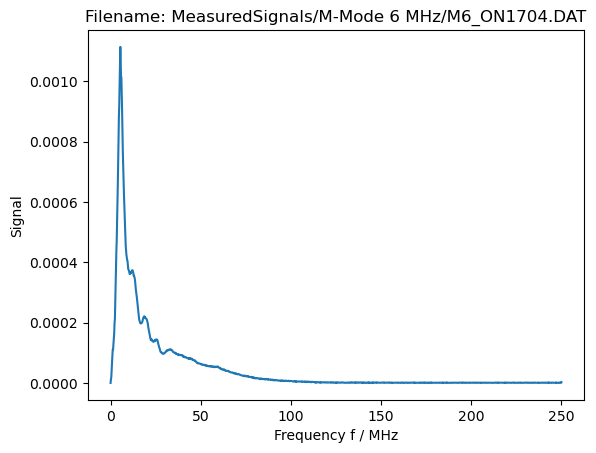

In [1394]:
plt.plot(Realpart(measurement_data["frequency"])/1E6,Amplitude(measurement_data["spectrum"])) #Function "Realpart" is used for getting the first half of the frequency vector
plt.xlabel("Frequency f / MHz")
plt.ylabel("Signal")
plt.title("Filename: {}".format(measurement_data["name"]))
plt.show()

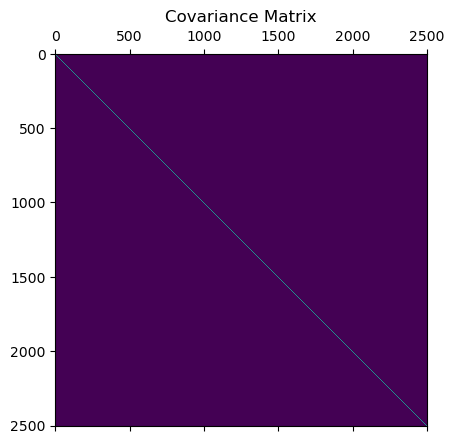

In [1395]:
plt.matshow(measurement_data["varspec"])
plt.title("Covariance Matrix");

### 2.7. Preprocessing of the hydrophone calibration data
The hydrophone data are imported into this script. The data are currently stored in a CSV file in the following format:

| Frequency | Real part | Imag. part | Variance of real part | Variance of imag. part | Covariance between real and imag. part | Amplitude | Amplitude level re. 1 V/Pa | Uncertainty of amplitude | Phase | Uncertainty of phase | Correlation coefficient between amplitude and phase|
|--|--|--|--|--|--|--|--|--|--|--|--|
|MHz|V/Pa|V/Pa|V²/Pa²|V²/Pa²|V²/Pa²|V/Pa|dB|V/Pa|rad|rad|range [-1 ... 1]|


For the calculation of this tutorial, only the data of the first 6 columns are used. The data of the remaining 6 columns were calculated from the original data given in the first 6 columns.

In the future, it is planned that the data will be stored in a digital calibration certificate [PTB2017](#literature). This format can also be used, except that a new import method has to be implemented which will handle the specified XML scheme. It will not be necessary to change the calculation.

If the calibration data is given in the form of amplitude and phase data, it is necessary to transform the data into real and imaginary parts, as the PyDynamic DFT works with Cartesian complex numbers. The transformation can be performed by the known equation $Z = A \cdot (\cos \varphi + i \sin \varphi)$. For this transformation, one can also use the PyDynamic function `AmpPhase2DFT`. If only amplitude data is available, the phase can be reconstructed using the Bode relation. For both cases, an example will be provided later on in this [document](#bode).

#### 2.7.1. Reading of the data files
In the following step, the data is read from the file.

In [1396]:
imax = None
hydcal_data = np.loadtxt(hydfilename,skiprows=1,delimiter=",")
hyd_data = {"name":hydfilename}
hyd_data["frequency"] = hydcal_data[:imax,0]*1E6
hyd_data["real"] = hydcal_data[:imax,1]
hyd_data["imag"] = hydcal_data[:imax,2]
hyd_data["varreal"] = hydcal_data[:imax,3]
hyd_data["varimag"] = hydcal_data[:imax,4]
hyd_data["kovar"] = hydcal_data[:imax,5]

In [1397]:
# The number of data points is shown in order to verify the correct reading of the data
len(hyd_data["frequency"])

1000

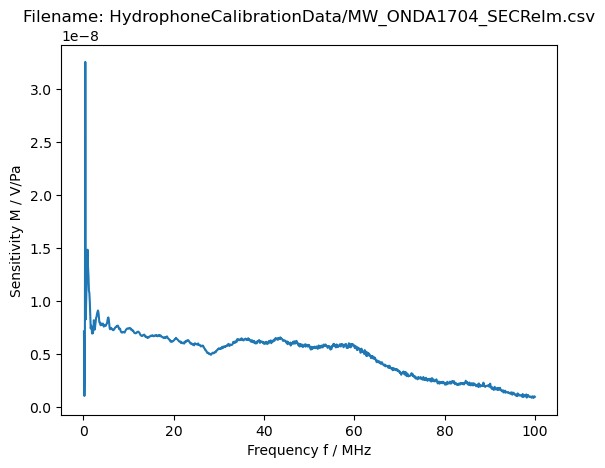

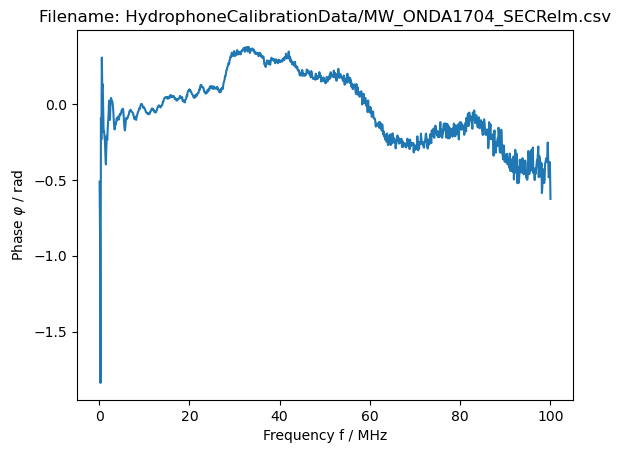

In [1398]:
plt.plot(hyd_data["frequency"]/1E6,np.sqrt(hyd_data["real"]**2+hyd_data["imag"]**2))
plt.xlabel("Frequency f / MHz")
plt.ylabel("Sensitivity M / V/Pa")
plt.title("Filename: {}".format(hyd_data["name"]))
plt.show()
plt.figure()
plt.plot(hyd_data["frequency"]/1E6,np.arctan2(hyd_data["imag"],hyd_data["real"]))
plt.xlabel("Frequency f / MHz")
plt.ylabel(r"Phase $\varphi$ / rad")
plt.title("Filename: {}".format(hyd_data["name"]))
plt.show()

#### 2.7.2. Selecting the frequency range of the calibration data to be used <a id="FreqRange"></a>

In [1399]:
# This is a help function to find the closest value in a list
# Its purpose is to find list indices fast
# For example when the list is [1,2,3] and the value = 2.2,
# then the return value for the index will be 1 as the number 2 in the list is the closest value to 2.2
def findnearestmatch(liste,value):
    i = np.argmin(abs(liste-value))
    return i

Select the lower and the upper frequency bound for the calibration data that is used for the deconvolution. Data outside of this interval is extrapolated. This method is useful for removing noisy calibration data which has a large uncertainty at very low or very high frequencies far from the acoustic work frequencies of the measured signals.

In [1400]:
fmin = 1E6
fmax = 60E6
infos["fmin_cal"] = fmin
infos["fmax_cal"] = fmax

In [1401]:
imin = findnearestmatch(hyd_data["frequency"],fmin)
imax = findnearestmatch(hyd_data["frequency"],fmax)

#### 2.7.3. Information about all data
Here, all information about the data is summarized.

In [1402]:
print("Measurement data")
dt = (measurement_data["time"][2]-measurement_data["time"][1])
print("Points time: {} dt: {} s fs: {} MHz".format(len(measurement_data["time"]),dt*len(measurement_data["time"]),round(1/dt)/1E6))
df = (measurement_data["frequency"][2]-measurement_data["frequency"][1])
print("Points frequency: {} df: {} MHz fmax: {} MHz".format(len(measurement_data["frequency"]),df/1E6,max(measurement_data["frequency"])/1e6))
print("Hydrophone calibration data")
print("Points: {} fmin: {} MHz fmax: {} MHz df {} Hz".format(len(hyd_data["frequency"]),hyd_data["frequency"][1]/1E6,hyd_data["frequency"][-1]/1E6,hyd_data["frequency"][2]-hyd_data["frequency"][1]))
print("Selected range: {} - {} MHz".format(hyd_data["frequency"][imin]/1e6,hyd_data["frequency"][imax]/1e6))

Measurement data
Points time: 2500 dt: 5e-06 s fs: 500.0 MHz
Points frequency: 2502 df: 0.19999999999999998 MHz fmax: 249.99999999999997 MHz
Hydrophone calibration data
Points: 1000 fmin: 0.2 MHz fmax: 100.0 MHz df 100000.0 Hz
Selected range: 0.1 - 50.0 MHz


#### 2.7.4. Interpolation and extrapolation of calibration data
As in general, the calibration data may have a different sample rate and a different frequency resolution, the data needs to be interpolated so that it matches the sample rate of the hydrophone voltage data of the measurement.
For deconvolution, the following conditions must be obeyed:
* same number of points
* same frequency interval
* same frequency step

This can be achieved in several ways. One method might be, for example, the interpolation and the extrapolation of the hydrophone calibration data to the given frequency vector of the measurement.
Note that one condition will automatically be followed by the two other conditions.

In general, it is important to specifically consider data at very high frequencies and at very low frequencies, where no calibration data may be available. To get reasonable data even for these ranges, an extrapolation must be performed.

In this example, the interpolation and the extrapolation are performed in a straightforward way by a linear interpolation of the data and of the uncertainty. Interpolation methods supplied by [PyDynamic](#literature) were used. They are based on a work by White [[White2017](#literature)]. The extrapolation is performed by using the first and the last value of the chosen range and by keeping these values as constants outside of the range of the original data set. This is also applied in order to extrapolate the uncertainty. This approach is the most universal method. However, it should be noted that the method has some drawbacks. Due to the interpolation, additional uncertainties may be introduced which cannot be estimated easily, and the extrapolation possibily introduces larger uncertainties for values for which no original data is available. <span style="color:red"> Such additional uncertainties are not estimated in this tutorial.</span> Values with zero cannot be chosen for the extrapolation as a division by the sensitivity is carried out. Therefore, choosing constant values for frequencies outside of the calibration range is the simplest approach. It might not be the most realistic one. However, as long as the measured signal components in the extrapolated frequency ranges are small, the final result will not be affected much.

A more advanced approach would be to find a mathematical function of the hydrophone frequency response, for instance by fitting an appropriate model to the hydrophone calibration data, and to use this function in order to obtain a data set with the required frequency points.

Impulse calibration methods as described in [[Wilkens2019](#literature)] may also be applied to experimentally extrapolate in a relative way calibration data from formal calibration certificates covering only part of the range.

In [1403]:
hyd_interpolated = {"frequency":measurement_data["frequency"]}

dump, hyd_interpolated["real"], hyd_interpolated["varreal"], Creal = PyDynamic.uncertainty.interpolate.interp1d_unc(
    measurement_data["frequency"][0:int(len(measurement_data["frequency"])/2)],
    hyd_data["frequency"][imin:imax+1],
    hyd_data["real"][imin:imax+1],
    hyd_data["varreal"][imin:imax+1],
    bounds_error = False, fill_value = "extrapolate", fill_unc = "extrapolate", returnC = True)

dump, hyd_interpolated["imag"], hyd_interpolated["varimag"], Cimag = PyDynamic.uncertainty.interpolate.interp1d_unc(
    measurement_data["frequency"][0:int(len(measurement_data["frequency"])/2)],
    hyd_data["frequency"][imin:imax+1],
    hyd_data["imag"][imin:imax+1],
    hyd_data["varimag"][imin:imax+1],
    bounds_error = False, fill_value = "extrapolate", fill_unc = "extrapolate", returnC = True)

hyd_interpolated["frequency"] = measurement_data["frequency"]

hyd_interpolated["imag"][0] = 0  # Must be 0 by definition
hyd_interpolated["imag"][-1] = 0
hyd_interpolated["varimag"][0] = 0  # Must be 0 by definition
hyd_interpolated["varimag"][-1] = 0

hyd_interpolated["kovar"] = np.diag(Creal.dot(np.diag(hyd_data["kovar"][imin:imax+1]))).dot(Cimag.T)
hyd_interpolated["kovar"][0] = 0 #Remove elements
hyd_interpolated["kovar"][-1] = 0

#### 2.7.5. Plot of the interpolated hydrophone data

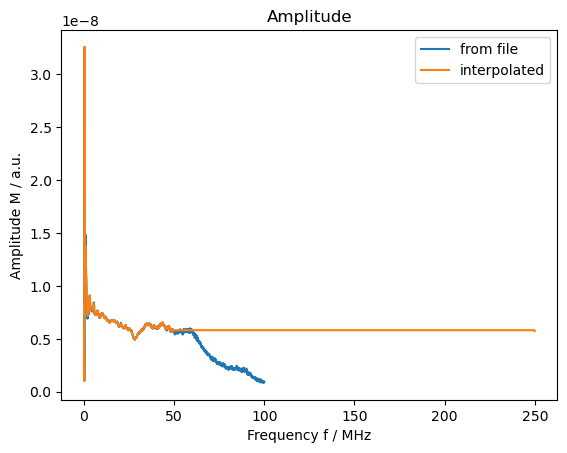

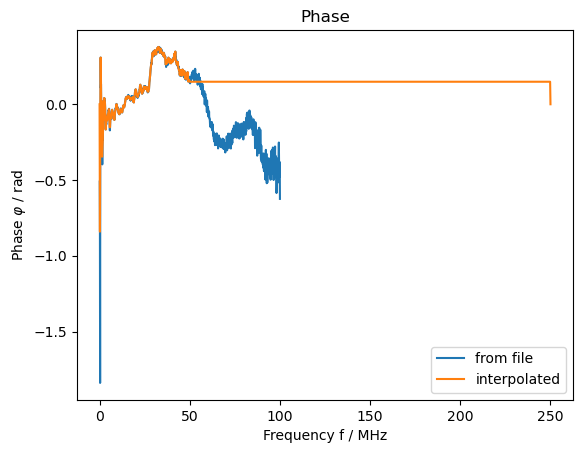

In [1404]:
plt.figure()
plt.plot(Realpart(np.append(hyd_data["frequency"]/1E6,hyd_data["frequency"])),Amplitude(np.append(hyd_data["real"],hyd_data["imag"])))
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,Amplitude(np.append(hyd_interpolated["real"],hyd_interpolated["imag"])))
plt.title("Amplitude")
plt.xlabel("Frequency f / MHz")
plt.ylabel(r"Amplitude M / a.u.")
plt.legend(["from file","interpolated"])

plt.figure()
plt.plot(Realpart(np.append(hyd_data["frequency"],hyd_data["frequency"]))/1E6,Phase(np.append(hyd_data["real"],hyd_data["imag"])))
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,Phase(np.append(hyd_interpolated["real"],hyd_interpolated["imag"])))
plt.title("Phase")
plt.xlabel("Frequency f / MHz")
plt.ylabel(r"Phase $\varphi$ / rad")
plt.legend(["from file","interpolated"])

#### 2.7.6. Transformation of the hydrophone data
The hydrophone data is transformed into the time domain and plotted to visualize the impulse response of the hydrophone. The impulse response is also useful for checking the transfer characteristic of the hydrophone. An ideal hydrophone should show a short signal peak which, in the most ideal case, is comparable to a delta pulse. Real hydrophones have a longer peak and exhibit a structure after the first rise which is due to the frequency characteristics. The signals occurring before the main peak should be small, as they are an indicator of the fact that the causality of the signal is being violated. This might indicate that the calibration went wrong. A typical phenomenon that can be observed is [Gibbs' ringing](https://en.wikipedia.org/wiki/Gibbs_phenomenon) of the signal before the main peak.

If the peak appears to be shifted in time, this indicates that the phase has a linear offset. This happens if, during hydrophone calibration, a time delay is not properly compensated for. For deconvolution, this is only a minor issue, as it will only introduce a small time delay between the measured signal and the deconvolved signal, but it will not affect the acoustic pulse waveform.

In [1405]:
x = np.append(hyd_interpolated["real"],hyd_interpolated["imag"])
a = np.hstack([np.diag(hyd_interpolated["varreal"]),np.diag(hyd_interpolated["kovar"])])
b = np.hstack([np.diag(hyd_interpolated["kovar"]),np.diag(hyd_interpolated["varimag"])])
ux = np.vstack([a,b])
[imp,uimp] = PyDynamic.GUM_iDFT(x,ux)
np.shape(ux)

(2502, 2502)

In [1406]:
dt = 1/(hyd_interpolated["frequency"][1]-hyd_interpolated["frequency"][0])
testtime = np.linspace(-dt/2,dt/2,np.size(imp)) #only for visualization, not for calculation, as no correction is performed for the last data point!

Text(0, 0.5, 'Signal / a.u.')

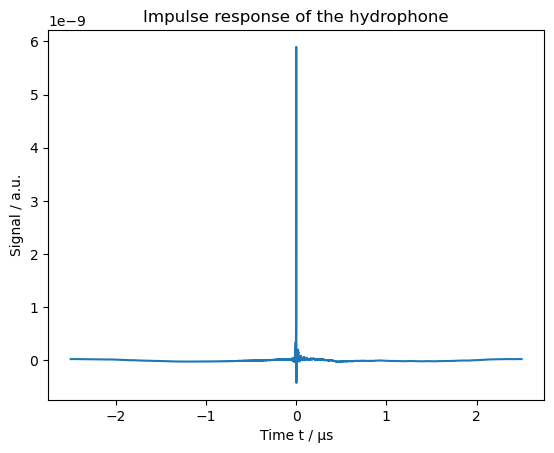

In [1407]:
plt.plot(testtime/1E-6,np.fft.fftshift(imp))
#plt.plot(testtime/1E-6,np.fft.fftshift(imp+2*np.sqrt(np.diag(uimp))))
#plt.plot(testtime/1E-6,np.fft.fftshift(imp-2*np.sqrt(np.diag(uimp)))) #show uncertainty
plt.title("Impulse response of the hydrophone")
plt.xlabel("Time t / µs")
plt.ylabel("Signal / a.u.")

#### 2.7.7. Alternative to an interpolation
An alternative to the interpolation of the hydrophone calibration data in the frequency domain might be [upsampling](https://en.wikipedia.org/wiki/Upsampling) and [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing) in combination with the zero filling/padding of the hydrophone measurement data in the time domain. When using this method, care must be taken to ensure that the time steps and the sample rates of the data sets fit together. This method can be applied less universally, but it has the advantage that the full uncertainty propagation can be implemented directly by means of GUM2DFT.
### 2.8. How should we deal with frequency ranges for which no calibration data is available? Extrapolation
When performing hydrophone measurements for high ultrasonic frequencies or for high amplitudes that lead to many harmonics of nonlinearly propagated waveforms, the problem may arise that the calibration data does not cover the complete frequency range of the measurement, in particular at very low frequencies down to DC and at very high frequencies up to the Nyquist frequency of the measurement. The aim should be to obtain calibration data with the largest possible bandwidth in order to achieve the highest reliability of the deconvolution process.
However, technical factors may limit the availability of experimental calibration data for specific frequency ranges. Extrapolation may then be applied to produce the missing calibration data outside of this calibration frequency range. For membrane hydrophones with rather a flat frequency response, the modulus value of the first known and of the last known calibration data point can be used for a constant value extrapolation of the modulus data. The phase must then be adjusted to meet linear phase conditions. For other hydrophones which exhibit a low-pass characteristic and a fast drop in the frequency response at high frequencies, a linear extrapolation using the final slope may be used. The modulus must stay finite to avoid division by zero. In any case, the ambiguity of the hydrophone sensitivity in the extrapolation ranges should be reflected in the uncertainty estimations in those regions. It should be noted that the impact which the extrapolated calibration data and the uncertainty have on the deconvolution results depends on the spectral composition of the waveform measured and on the choice of the regularization filter's cut-off frequency (see chapter [5](#RegFilter)). If the cut-off frequency of the regularization filter is low, the extrapolated data at high frequencies will be partially cut, and therefore the uncertainty contribution resulting from the extrapolation will be small. On the other hand, care must be taken not to lose significant high-frequency components of the waveform due to low filtering cut-off frequencies. 
An optimization approach would aim to achieve the best compromise between the uncertainty introduced by the regularization filtering and the uncertainty introduced by the extrapolation [[Eichstaedt2017](#literature)].


### _Optional_ 2.9. Estimation of the phase response by means of the Bode equation <a id="bode"></a>
In many cases, only amplitude data was measured during calibration and the phase information is missing. Therefore, an example is given here of how to use amplitude-only data and how to reconstruct the phase information using the Bode equation [[Bechhoefer2011](#literature)]. The application of the Bode phase-gain relation is straightforward. It is based on the same principles as the application of Hilbert transform methods [[Bloomfield2014](#literature)]. To use this method, only the modulus of the hydrophone sensitivity, together with the uncertainty, must be known. Furthermore, it must be kept in mind that the Bode equation is related to linear time-invariant systems. Therefore, the hydrophone must behave like such a system. 

For this demonstration, the measured hydrophone calibration data (real and imaginary components) is used and in a first step, the amplitude and its uncertainty are calculated. The data is stored to – and then again loaded from – a text file to demonstrate the handling of such data stored in files. Afterwards, the data is interpolated and extrapolated to the desired frequency range. Afterwards, the phase is reconstructed from the modulus data using the Bode equation. Finally, the amplitude and the phase are transformed into real and imaginary components, as this format is required for the following deconvolution process.


#### 2.9.1. Calculation of modulus values from hydrophone calibration data to simulate a case
In this step, the amplitude $r_i$ is calculated from the real part $a_i$ and from the imaginary part $b_i$ at frequency $f_i$. The variables are named according to the fundamental equation of complex numbers $r \exp(i \varphi) = a + bi$ . For both values, the variances are given as $u_{a_i}$ and $u_{b_i}$ and the covariance as $u_{a_i b_i}$. Remember that the variance $u_{a_i}=\sigma^2$ is the squared uncertainty $\sigma$.

The equation to calculate the amplitude is: $r_i = \sqrt{a_i^2+b_i^2}$.

The uncertainty propagation is performed according to [[GUM2008](#literature)]. The partial derivatives are $\frac{\partial r_i}{\partial a_i} = \frac {a_i} {\sqrt{a_i^2+b_i^2}}$ and $\frac{\partial r_i}{\partial b_i} = \frac {b_i} {\sqrt{{a_i}^2+{b_i}^2}}$.

Therefore, the total variance is:
$u_{r_i}= \left( \frac{\partial r_i}{\partial a_i} \right)^2 u_{a_i} + \left( \frac{\partial r_i}{\partial b_i} \right)^2 u_{b_i} + 2 \left( \frac{\partial r_i}{\partial a_i} \right)  \left( \frac{\partial r_i}{\partial b_i} \right) u_{a_i b_i} $ ([GUM2008](#literature) Equation 13)

Below, the use of the complex hydrophone calibration data, or of the modulus data with reconstructed Bode phase (see 2.9.3) can be activated for the further calculations.  <a id="UseBode"></a>

In [1408]:
usebode = True
#usebode = False
if usebode:
    print("Calculation of phase by amplitude data and Bode equation will be used.")
else:
    print("Calculation of phase will be skipped")

Calculation of phase will be skipped


In [1409]:
if usebode:
    amp = np.sqrt(hyd_data["real"]**2+hyd_data["imag"]**2)
    summand_real = (hyd_data["real"]/amp)**2*hyd_data["varreal"]
    summand_imag = (hyd_data["imag"]/amp)**2*hyd_data["varimag"]
    summand_corr = 2* (hyd_data["real"]/amp)*(hyd_data["imag"]/amp) *hyd_data["kovar"]
    varamp = summand_real+summand_imag+summand_corr
    freq = hyd_data["frequency"]
else:
    freq = hyd_data["frequency"]
    print("Skipped")   

Skipped


In [1410]:
# Here the frequency range is trimmed
if usebode:
    freq = freq[imin:imax+1]
    amp = amp[imin:imax+1]
    varamp = varamp[imin:imax+1]
    print("Frequency range: {0:.3f} MHz to {1:.3f} MHz".format(freq[0]/1E6,freq[-1]/1E6))
else:
    print("Skipped")   

Skipped


The following two steps are to demonstrate how to handle a calibration data set that is saved in a text file. They can be skipped. In a first step, the data is exported as a text file, and afterwards the text file is read back. It should enable users to use their own calibration data for evaluation. To use ones's own calibration data, the filepath `filenameamp` in the second step just needs to be adjusted.

In [1411]:
# To enable the export of amplitude data and the import of amplitude calibration data, set the variable from false to true
exportamplitudedata = False
importamplitudedata = False

In [1412]:
#f useamplitudedata:
#This saves the file
if (exportamplitudedata & usebode):
    header = "frequency f/Hz;Hydrophone sensitivity M/(V/Pa);uncertainty (k=1) u_m/(V/Pa)"
    data = np.transpose( [freq,amp,np.sqrt(varamp)])
    filenameamp = "AmplitudeData/"+infos["hydrophonename"]+"_amplitude.csv" #Filename is created automatically
    np.savetxt(filenameamp,data,header = header,delimiter = ";")
    print("File was exported: " + filenameamp)
else:
    print("skipped")

skipped


In the next step, it is possible to load your own files which contain the amplitude of the hydrophone sensitivity. The phase will be reconstructed by means of the Bode equation. All data provided in this file will be used so that the frequency range is defined by this data file and not by the constraints defined in 2.7.2.

In [1413]:
#filenameamp = "AmplitudeData/?????.csv" #change this line to give other filename
#filenameamp = "AmplitudeData/MON1704Bu.csv"
#filenameamp = "AmplitudeData/ONDA1704_amplitude04.csv"
#filenameamp = "AmplitudeData/M_HGL1704b210515u4.csv"

In [1414]:
#This step loads the previously saved data. For your own data set, the filename needs to be adjusted.
if (importamplitudedata & usebode):
    data = np.loadtxt(filenameamp,skiprows=0,delimiter=";")
    freq = data[:,0]
    amp = data[:,1]
    varamp = data[:,2]**2
    print("File was imported: " + filenameamp)
else:
    print("skipped")

skipped


#### 2.9.2 Interpolation of data
Now the amplitude data, together with the variance, is calculated and available. At this point, it is also possible to use one's own data for the amplitude. In the following step, the calibration data is interpolated to the frequency scale of the hydrophone measurement data.

In [1415]:
if usebode:
    ampip = np.interp(measurement_data["frequency"][0:int(len(measurement_data["frequency"])/2)],freq,amp)
    varampip = np.interp(measurement_data["frequency"][0:int(len(measurement_data["frequency"])/2)],freq,varamp)
    freqip = measurement_data["frequency"][0:int(len(measurement_data["frequency"])/2)]

And here, the data ist plotted.

In [1416]:
if usebode:
    plt.plot(freq/1E6,amp)
    plt.plot(freq/1E6,np.sqrt(varamp))
    plt.plot(freqip/1E6,ampip)
    plt.plot(freqip/1E6,np.sqrt(varampip))
    plt.legend(["original data","uncertainty","interpolated data","interpolated uncertainty"]);
    plt.xlabel("Frequency f / MHz");
    plt.ylabel("Amplitude A / a.u.");

#### 2.9.3. Reconstruction of the phase by using the Bode equation
The Bode equation is implemented in the following step, together with the uncertainty propagation for the phase. The equation  [[Bechhoefer2011](#literature)] is given as:

$\varphi_i = 2 \frac {f_i} {\pi} \Delta f \sum_j^{i\ne j}  \frac{\ln(A_j) - \ln(A_i)}{f_j^2-f_i^2} $

with $\Delta f = f_{2}-f_1 (=f_{i+1}-f_i) $ (the frequency scale is equidistant)

For the uncertainty estimation, it is assumed that the frequency scale is free of any uncertainty.

The partial derivative for $i \ne j$ is $\frac{\partial \varphi_i}{\partial A_j}= 2 \frac {f_i} {\pi} \Delta f \frac{1}{A_j (f_j^2-f_i^2)}  $ (For $i=j$, the value and the derivative are 0 anyway.)

The variance is calculated in the usual way as
$u_{\varphi_i}=\sum_j^{j \ne i} \left(\frac{\partial \varphi_i}{\partial A_j}\right)^2 u_{A_j} $

In [1417]:
def bodeequation(frequencies,amplitudes,varamplitudes):
    df = frequencies[1]-frequencies[0]
    phase = np.zeros_like(amplitudes)
    varphase = np.zeros_like(amplitudes)
    for i in range(0,np.size(frequencies)):
        numerator = np.log(amplitudes)-np.log(amplitudes[i])
        denominator = frequencies**2 - frequencies[i]**2
        denominator[i] = 1 #prevents the occurrence of 0 in the denominator at i
        phase[i] = 2.* frequencies[i]/np.pi * df * np.sum(numerator/denominator)
        denominatoru = amplitudes * denominator
        numeratoru = np.ones_like(denominatoru)
        numeratoru[i] = 0#ignores value at i, as this is not part of the sum anyway
        varphase[i] = (2.* frequencies[i]/np.pi * df)**2 * np.sum(((numeratoru/denominatoru)**2) *varamplitudes)
    return phase,varphase

In [1418]:
# here, the calculation of the phase is performed
if usebode:
    phaseip,varphaseip = bodeequation(freqip,ampip,varampip)
else:
    print("skipped")

skipped


In [1419]:
if usebode:
    plt.plot(freqip/1E6,phaseip)
    plt.plot(freqip/1E6,phaseip+2*np.sqrt(varphaseip))
    plt.plot(freqip/1E6,phaseip-2*np.sqrt(varphaseip))
    plt.title("Reconstructed phase");
    plt.xlabel("Frequency f / MHz");
    plt.ylabel(r"Phase $\varphi$ / rad");
    plt.legend(["value","value+2*uncertainty","value-2*uncertainty"]);
else:
    print("skipped")

skipped


In [1420]:
if usebode:
    (x,ux) = PyDynamic.AmpPhase2DFT(ampip, phaseip, np.hstack([varampip,varphaseip]))
    # Uncertainty calculation is automatically performed by the PyDynamic function
    [imp,uimp] = PyDynamic.GUM_iDFT(x,ux)
    infos["PhaseByBode"] = True
    print("Phase reconstruction using the Bode equation is applied.")
else:
    infos["PhaseByBode"] = False
    print("Complex hydrophone data is applied.")

Complex hydrophone data is applied.


In [1421]:
if usebode:
    plt.plot(freqip/1E6,Realpart(x))
    plt.plot(freqip/1E6,Imagpart(x))
    plt.plot(freqip/1E6,Amplitude(x))
    plt.title("Reconstructed signal")
    plt.xlabel("Frequency f / MHz")
    plt.ylabel("Amplitude u / a.u.")
    plt.legend(["real","imag","abs"])

In [1422]:
if usebode:
    plt.matshow(ux);
    plt.title("Covariance Matrix");

In [1423]:
if usebode:
    n = np.max(np.shape(ux))
    ureal = np.diag(ux)[0:(n//2)]
    uimag = np.diag(ux)[(n//2):]
    uvar = np.diag(ux,n//2)
    plt.plot(freqip/1E6,np.sqrt(ureal))
    plt.plot(freqip/1E6,np.sqrt(uimag))
    plt.plot(hyd_data["frequency"]/1E6,np.sqrt(hyd_data["varreal"]))
    plt.plot(hyd_data["frequency"]/1E6,np.sqrt(hyd_data["varimag"]))
    plt.title("Uncertainty");
    plt.xlabel("Frequency f / MHz");
    plt.ylabel("Amplitude u / a.u.");
    plt.legend(["real","imag","real from calibration","imag from calibration"]);

In [1424]:
if usebode:
    plt.plot(freqip[1:-1]/1E6,uvar[1:-1]/np.sqrt(uimag[1:-1])/np.sqrt(ureal[1:-1]))
    plt.plot(hyd_data["frequency"]/1E6,hyd_data["kovar"]/np.sqrt(hyd_data["varreal"])/np.sqrt(hyd_data["varimag"]))
    plt.title("Correlation")
    plt.xlabel("Frequency f / MHz");
    plt.ylabel("Amplitude u / a.u.");
    plt.legend(["calculated from amplitude","from calibration"]);

## 3. Deconvolution
Deconvolution is performed using the function supplied with the GUM2DFT package. The Fourier-transformed time-domain voltage signal of the hydrophone measurement is used as the numerator and the hydrophone frequency response is used as the denominator.

In [1425]:
deconv = {"frequency":measurement_data["frequency"]}
(deconv["p"],deconv["Up"]) = PyDynamic.DFT_deconv(x,measurement_data["spectrum"],ux,measurement_data["varspec"])

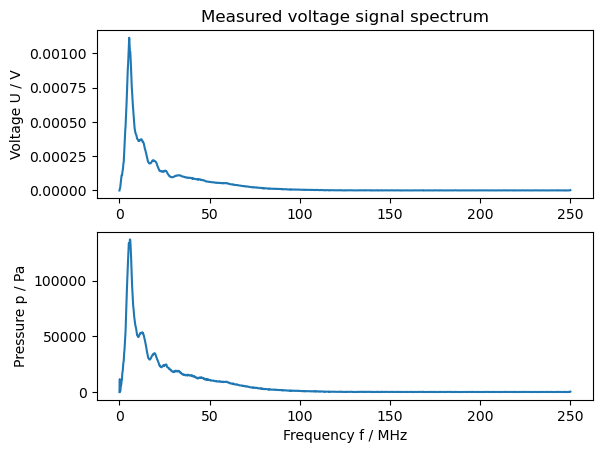

In [1426]:
plt.subplot(2,1,1)
plt.plot(Realpart(measurement_data["frequency"])/1E6,Amplitude(measurement_data["spectrum"]))
plt.title("Measured voltage signal spectrum")
plt.ylabel("Voltage U / V")
plt.subplot(2,1,2)
plt.plot(Realpart(deconv["frequency"])/1e6,Amplitude(deconv["p"]))
plt.xlabel("Frequency f / MHz")
plt.ylabel("Pressure p / Pa");


## 4. Transformation to the time domain
The spectrum of the measured signal which has been corrected for the frequency weighting of the hydrophone is now transformed from the frequency domain to the time domain. To obtain the data in the time domain, the inverse Fourier transformation is applied. The normation is reversed.

In [1427]:
deconvtime = {"t":measurement_data["time"]}
(deconvtime["p"],deconvtime["Up"]) = PyDynamic.GUM_iDFT(deconv["p"],deconv["Up"])
deconvtime["p"] = deconvtime["p"]/2*np.size(deconvtime["t"])
deconvtime["Up"] = deconvtime["Up"]/4*np.size(deconvtime["t"])**2

Text(0, 0.5, 'Pressure p / MPa')

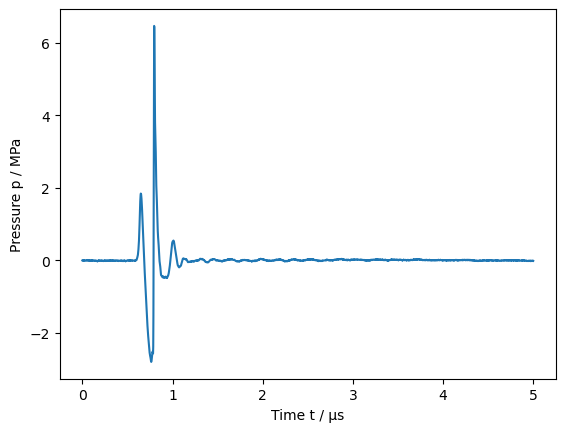

In [1428]:
plt.plot(deconvtime["t"]/1E-6,deconvtime["p"]/1E6)
plt.xlabel("Time t / µs")
plt.ylabel("Pressure p / MPa")

Text(0.5, 1.0, 'Covariance Matrix')

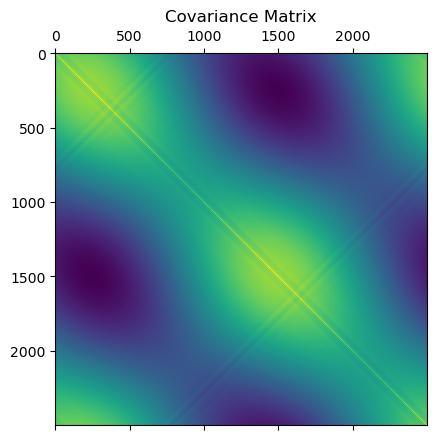

In [1429]:
plt.matshow(deconvtime["Up"])
plt.title("Covariance Matrix")

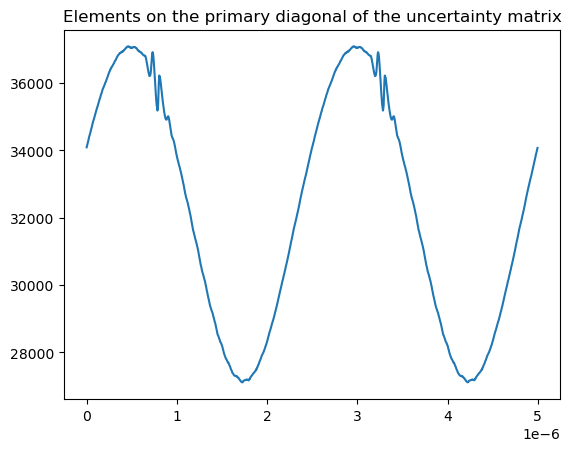

In [1430]:
plt.plot(deconvtime["t"],np.sqrt(np.diag(deconvtime["Up"])))
plt.title("Elements on the primary diagonal of the uncertainty matrix");

At this point, the basic deconvolution is finished and the resulting waveform and the associated uncertainties are obtained. In the following steps, regularization filtering is added to the deconvolution to account for any numerical noise issues of the – generally speaking – "ill-posed" mathematical problem of deconvolution. The signal-to-noise ratio is improved using the regularization filter, and the uncertainty estimation for this procedure is performed.

## 5. Regularization filtering <a id='RegFilter'></a>
The deconvolution process will amplify the high-frequency noise since usual hydrophones display a low-pass characteristic. To limit this effect, a low-pass filter can be used as a regularization filter.
### 5.1. Choice of the regularization filter
In this tutorial, different numerical low-pass filters can be used for regularization. A standard low-pass filter, a low-pass filter with critical damping and a Bessel filter were implemented as well as the option of not filtering. Other filter functions may be added, if needed.

The -3 dB cut-off frequency of the filter is set here:

In [1431]:
fc = 100e6 #cut of frequency (Hz) #typical range 100 MHz to 200 MHz
#definition of the symbol for symbolic integration
fsym = sym.symbols("fsym") #frequency as the symbol for symbolic calculation

In [1432]:
ifilt = "LowPass"
#ifilt = "CriticalDamping"
#ifilt = "Bessel"
#ifilt = "None"
if ifilt == "CriticalDamping":
    #Low pass with critical damping
    Hl = 1/(1+1.28719*1j*fsym/fc+0.41421*(1j*fsym/fc)**2) #Quelle S.316 Achenbach1988 (System Synthese)
    infos["filter"] = "Critical Damping"
    infos["filter_fmax"] = fc
elif ifilt == "Bessel":
    #Bessel filter
    Hl = 1/(1+1.3617*1j*fsym/fc-0.6180*fsym**2 / fc**2) #Quelle S.338 Achenbach1988 (System Synthese)
    infos["filter"] = "Bessel"
    infos["filter_fmax"] = fc
elif ifilt == "LowPass":
    #Standard low-pass filter
    Hl = 1/(1+1j*fsym/(fc*1.555))**2 #Quelle [Wilkens2016], II.D. Scaled from -6 dB to -3 dB cut-off frequency parameter 
    infos["filter"] = "LowPass"
    infos["filter_fmax"] = fc 
elif ifilt == "None":
    #No regularization filter
    Hl = 1 
    infos["filter"] = "None"
    infos["filter_fmax"] = fc

# Achenbach1988
# Johann-Jost Achenbach, System-Synthese Grundlagen der Synthesemethoden kontinuierlicher 
# und diskreter Systeme und Filter für die Praxis, VDI Verlag Düsseldorf, 1988

Text(0, 0.5, 'Magnitude')

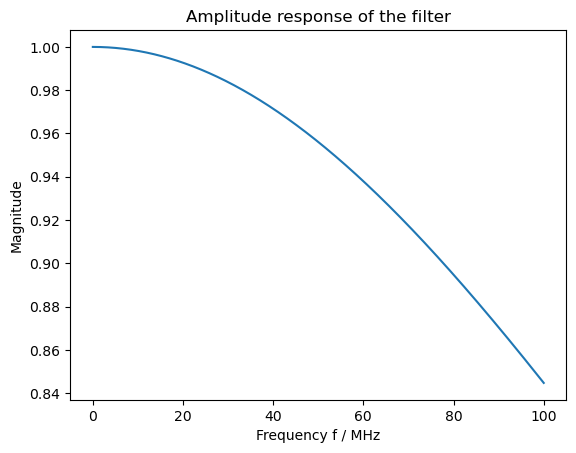

In [1433]:
#discretization of filter for plotting
fktHl=sym.lambdify(fsym,Hl)
ftest2 = np.linspace(0,1E8,1000)
yH1=np.array(list(map(fktHl,ftest2)))
plt.plot(ftest2/1E6,np.abs(yH1))
#plt.plot(ftest2/1E6,np.abs(1-yH1))
plt.title("Amplitude response of the filter")
plt.xlabel("Frequency f / MHz")
plt.ylabel("Magnitude")

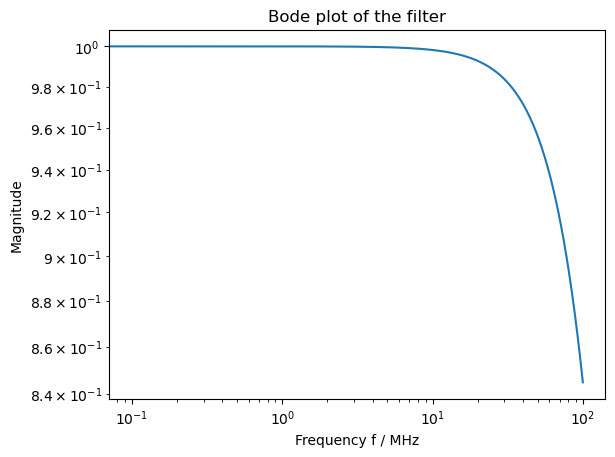

In [1434]:
plt.loglog(ftest2/1E6,np.abs(yH1))
plt.title("Bode plot of the filter");
plt.xlabel("Frequency f / MHz");
plt.ylabel("Magnitude");

#### _Note on the filter phase_
Each filter introduces a phase shift. At DC, the phase is 0 and at $\infty$, it is $n \cdot 90 ^\circ$, where $n$ is the order of the filter. This can introduce a large phase shift and when calculating the uncertainty, it can result in a factor (relative uncertainty) of 2 (200 % !) compared to the original signal. (E.g. a signal at the frequency f has the value 1 sin(2 pi f t). After filtering with amplitude 1 and phase $180^\circ$, the signal will be -1 sin(2 pi f t). Therefore, the change in the signal (as phasor in the complex plane) will be 2, even if the signal waveform is not altered but if it is just shifted in time. This might overestimate the uncertainty.) The phase response obeys the causality condition, i.e. that no signal can appear after the filtering before the signal is applied to the filter. Strictly speaking, this condition applies to real time signal processing only. Filters which calculate stored signals can also have a phase response that deviates from this (with a lower phase response), but this can lead to the fact that parts of the signal appear at an earlier point in time.
### 5.2. *Optional:* Minimizing the phase lag at low frequencies
In the following step, the phase can be optimized in such a way that the indicated uncertainty is reduced. The procedure subtracts the phase change component that is linear with the frequency from the filter characteristics. Alternatively, this step can be skipped. By minimizing the phase of the regularization filter, it is possible to minimize the indicated uncertainty. The simple explanation for this is that a phase shift of $180^\circ$ changes the sign, thus a difference is converted into a sum. Therefore, it is helpful to keep the phase change in the pass-band region as low as possible.
For example, a sinusoidal 10 MPa signal that is shifted by $180^\circ$ in phase results in a difference of 20 MPa even if the signal is unaltered and only a time delay is introduced.
The effect can be observed by comparing the estimated uncertainty for the uncorrected with the estimated uncertainty for the corrected phase, which is calculated at the end of the next step.

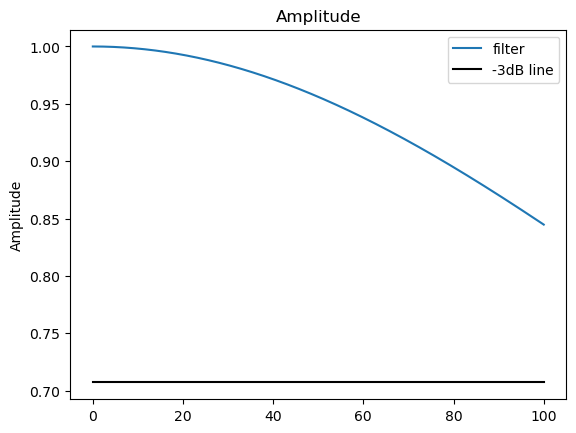

In [1435]:
plt.plot(ftest2/1E6,np.abs(yH1))
plt.plot(ftest2/1E6,np.sqrt(0.5)*np.ones_like(yH1.real),"k-")
plt.title("Amplitude")
plt.ylabel("Amplitude")
plt.legend(["filter","-3dB line"])

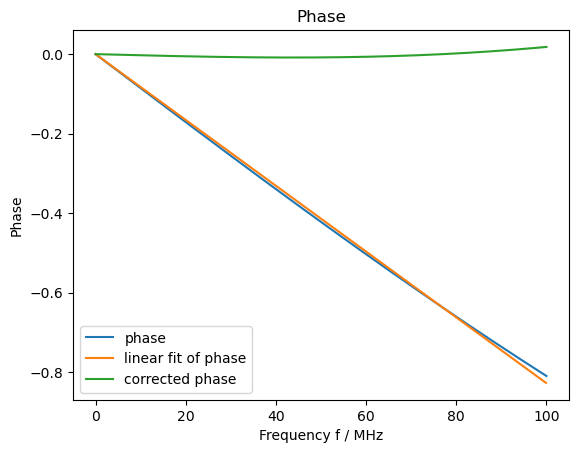

In [1436]:
plt.plot(ftest2/1E6,np.angle(yH1))
plt.title("Phase")
#Finding the -3dB point (approximation only)
ind3dB = np.argmin(np.abs(np.abs(yH1)-np.sqrt(0.5)))
ftest2[ind3dB]

w = np.linalg.lstsq(np.array([ftest2[:ind3dB]]).T,np.angle(yH1[:ind3dB]),rcond=1)[0]

plt.plot(ftest2[:ind3dB]/1E6,w*ftest2[:ind3dB])
yH1new = yH1 * np.exp(-1j*w*ftest2)
plt.plot(ftest2/1E6,np.angle(yH1new))
plt.legend(["phase","linear fit of phase","corrected phase"])
plt.xlabel("Frequency f / MHz")
plt.ylabel("Phase")
yH1 = yH1new



Hl = Hl * (sym.cos(-fsym*w[0])+sym.I*sym.sin(-fsym*w[0]))
Hl
infos["phasecorr"] = True
fktHl = sym.lambdify(fsym,Hl)

### 5.3. Calculating the filter characteristic

In [1437]:
#Calculation of the filter characteristic for the given frequency range
yH1 = np.array(list(map(fktHl,Realpart(deconv["frequency"]))))
filt = np.hstack([np.real(yH1),np.imag(yH1)])

### 5.4. Applying the filter to the data

In [1438]:
regul = {"frequency":measurement_data["frequency"]}
(regul["p"],regul["Up"]) = PyDynamic.DFT_multiply(deconv["p"],filt,deconv["Up"])

## 6. Uncertainty estimation for regularization filtering
The regularization filter is a low-pass filter that removes high-frequency signal components. With regard to high-frequency noise, this is the desired effect. But at the same time, the filter will also remove high-frequency components of the actual waveform signal. Therefore, it is necessary to estimate the loss in the signal for a given ultrasonic waveform in order to be able to estimate the deviation of the deconvolved waveform from the true waveform.

In order to estimate the additional uncertainty that is introduced by the regularization filtering, the upper-bound function method described in [Eichstaedt2017](#literature) is applied. By means of this method, the impact of the induced systematic error is investigated quantitatively. This is done by considering a continuous upper-bound function in the frequency domain for the pressure modulus spectrum, using an approach with a simple basic function which has one parameter only. Prior knowledge is included (such as the monotonous decrease of the spectral components with increasing frequency – as can be expected for nonlinearly distorted acoustic pulse waveforms – and the typical noise at high frequencies that differs from the contribution of the signal).

### 6.1.  Wavelet-like model
For the uncertainty estimation, information is required about the signal at all frequencies, even if this information cannot be obtained by measurements. For that reason, it is necessary to carry out a signal approximation. In the publication of Eichstaedt and Wilkens [[Eichstaedt2017](#literature)], a wavelet-like approach was used. This is rather a simple approximation, for which no additional knowledge is necessary. On the other hand, the model is rather conservative and may overestimate the uncertainty. Better models for the approximation might be chosen. In the following, the wavelet will be defined and will be used to approximate the signal spectrum.

In [1439]:
def wavelet(f,sigma,scale = 1):
    w = 2*np.pi*f
    psi = w*scale*sigma*np.sqrt(np.e)*sym.exp(-1/2.*sigma**2 * w**2)
    return psi

For reasons of simplicity, finding the fundamental frequency of the signal is implemented here. This is achieved by searching for the highest peak in the spectrum. (The standard acoustic work frequency definitions may provide slightly different frequency results, but for estimating the uncertainty of the regularization by means of the upper-bound method, such differences are negligible.)

In [1440]:
affun = np.max(Amplitude(deconv["p"])) #Determination of the fundamental frequency
iffun = np.argmax(Amplitude(deconv["p"]))
ffun = deconv["frequency"][iffun]
searchwidth = int(iffun*0.1) #10% of the fundamental frequency. This parameter is used to define the interval to find higher harmonic components
print("Fundamental frequency: {0:.3f} MHz at index {1} with an amplitude of {2:.3f} MPa".format(ffun/1E6,iffun,affun/1E6))
hydempffun = np.sqrt(hyd_interpolated["real"][iffun]**2+hyd_interpolated["imag"][iffun]**2)
print("Hydrophone sensitivity: {0:.3e} V/Pa at {1:.3f} MHz".format(hydempffun,hyd_interpolated["frequency"][iffun]/1e6))
if iffun < 2:
    print("The maximum was found unexpectedly at low frequencies close to DC. You may remove the DC component!")
    

Fundamental frequency: 5.800 MHz at index 29 with an amplitude of 0.137 MPa
Hydrophone sensitivity: 7.420e-09 V/Pa at 5.800 MHz


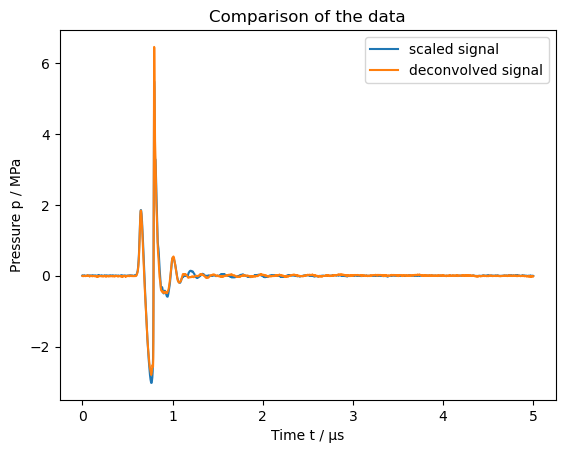

In [1441]:
##Plot: comparison of data
#1. measured voltage * hydrophone sensitivity at fundamental frequency
plt.plot(measurement_data["time"]/1e-6,measurement_data["voltage"]/hydempffun/1e6)
#2. deconvolved signal (without regularization filter)
plt.plot(deconvtime["t"]/1e-6,deconvtime["p"]/1e6)
plt.legend(["scaled signal","deconvolved signal"]);
plt.title("Comparison of the data");
plt.xlabel("Time t / µs");
plt.ylabel("Pressure p / MPa");

In [1442]:
def locmax(data,frequencylist,iffund,searchwidth,harmonicorder):
    # this function helps to find the local maxima in the spectrum
    # data: spectral amplitude data
    # frequencylist: frequency list
    # iffun: index of the fundamental frequency
    # searchwidth: number of bins to locate local maxima
    # harmonicorder: harmonic order
    
    #selecting data
    dataloc = data[(harmonicorder*iffund-searchwidth):(harmonicorder*iffund+searchwidth)]
    frequencylistloc = frequencylist[(harmonicorder*iffund-searchwidth):(harmonicorder*iffund+searchwidth)]
    amplitude = np.max(dataloc)
    freq = frequencylistloc[np.argmax(dataloc)]
    return (amplitude,freq)

The signal amplitudes at the different harmonic orders are determined and the wavelet-like model is created. The orders i = [1,3,8] are used here as the default setting as mentioned in [[Eichstaedt2017](#literature)], but they could be adjusted to the actual signal needs.

In [1443]:
#create wavelet
harmonicorder = [1,3,8]
fktw = 0
for ordn in harmonicorder:
    (amp,freq) = locmax(Amplitude(deconv["p"]),deconv["frequency"],iffun,searchwidth,ordn)
    sigma = 1/(2*np.pi*freq)
    fktw = fktw+wavelet(fsym,sigma,amp)
print(fktw)

0.0389489177102357*fsym*exp(-1.48632580261593e-14*fsym**2) + 0.00290681039263239*fsym*exp(-1.61415289256198e-15*fsym**2) + 0.000460746823748308*fsym*exp(-2.36294896030246e-16*fsym**2)


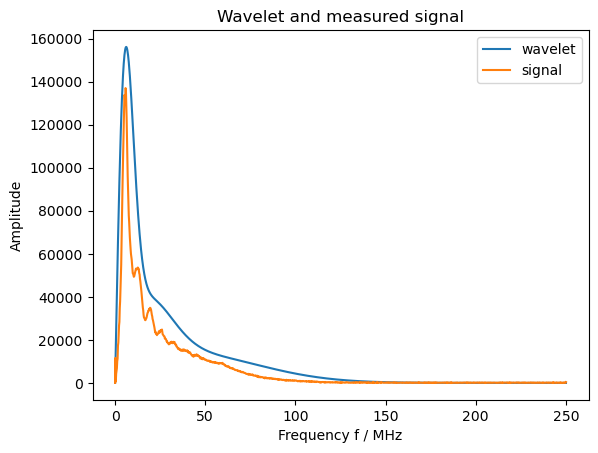

In [1444]:
fktw3 = sym.lambdify(fsym,fktw)
ytest3 = list(map(fktw3,Realpart(deconv["frequency"])))
plt.plot(Realpart(deconv["frequency"])/1E6,ytest3)
plt.plot(Realpart(deconv["frequency"])/1E6,Amplitude(deconv["p"]))
plt.title("Wavelet and measured signal");
plt.xlabel("Frequency f / MHz");
plt.ylabel("Amplitude");
plt.legend(["wavelet","signal"]);

The wavelet-like model approximates the shape of the signal spectrum. This works well for signals with basically only one main spectral band. But for the pulse-Doppler-mode, where the signal consists of a periodic repetition of cycles, a closer view is necessary. Due to the nature of the wavetrain signal, the components in the frequency domain are strongly confined around multiple harmonics of the fundamental frequency. The wavelet-like approximation, as defined in [[Eichstaedt2017](#literature)], scales the wavelet in such a way that the local maxima are enveloped. This can be problematic as such an upper bound approximation adds signal contributions at frequencies where the original signal had only minimal spectral content, and can lead to excessively large uncertainty contributions.


To address this, the following modification of the bound function scaling is introduced here. <span style="color:red">  It is a preliminary approach, and other solutions are currently under investigation. A future version of this tutorial will address this issue.</span>


The total sum of the spectral pressure amplitude components of a signal, $p_{total}$, has an upper limit and can be estimated from the spectrum. The equations are $p_{total}= \int_0^\infty |P(f)| df $ and for the discrete case $p_{total} = \sum_i |P_i| $. $P_i$ must be scaled in such a way that it represents the amplitude of the i-th component, resulting in a time domain signal as $p(t) = \sum_i P_i \exp(2 \pi f_i t) $. It should be emphasized that this value is just the worst case estimation which can be larger than the actually observed maximum pressure of the signal $\max(p(t))$ depending on the phase relations between spectral components.

A scaling factor $s$ for the wavelet-like approach is introduced which scales the upper bound function in such a way that the total sum of the pressure amplitudes of the wavelet is larger than that of the measured signal:


$$ p_{signal} = \int_0^\infty | P_{signal}( f) | df \le s \int_0^\infty | P_{wavelet}( f) | df = p_{wavelet} $$



To prevent an interaction between the low- and the high-frequency components, the condition is modified to find the supremum $s$ for $$  \int_0^{f_x} | P_{signal}( f) | df \le s \int_0^{f_x} | P_{wavelet}( f) | df $$ for all $f_x \in [0,\infty[$.



The calculation in this tutorial is performed with discrete experimental data. To find an approximated scaling factor $\tilde s$, the condition is rewritten to $$ \sum_{i=0}^{i_max} | P_{i,signal} | \le \tilde s \sum_{i=0}^{i_{max}} | P_{i,wavelet} | $$ with $i_{max}$  according to the relation $f_{fun}/2 \le f_{i_{max}} < f_{nyquist}$. The lower limit at half of the fundamental frequency of the ultrasonic signal was chosen to provide robustness of the calculation against low-frequency noise.

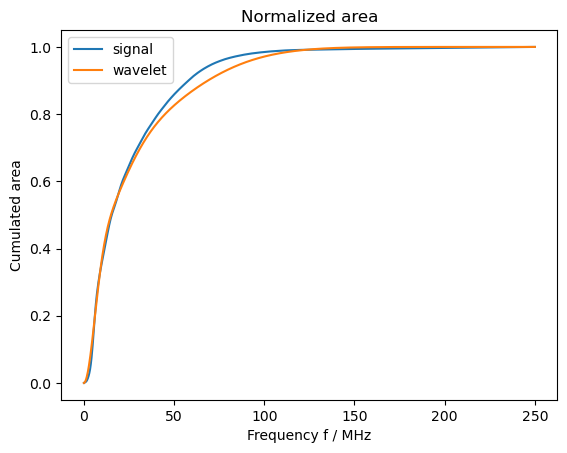

In [1445]:
idx = -1
psum = np.cumsum(Amplitude(deconv["p"]))
plt.plot(Realpart(deconv["frequency"])/1E6,psum/psum[idx])

wlsum = np.cumsum(ytest3)
plt.plot(Realpart(deconv["frequency"])/1E6,wlsum/wlsum[idx])
plt.title("Normalized area");
plt.xlabel("Frequency f / MHz")
plt.ylabel("Cumulated area");
plt.legend(["signal","wavelet"])

Text(0, 0.5, 'Ratio')

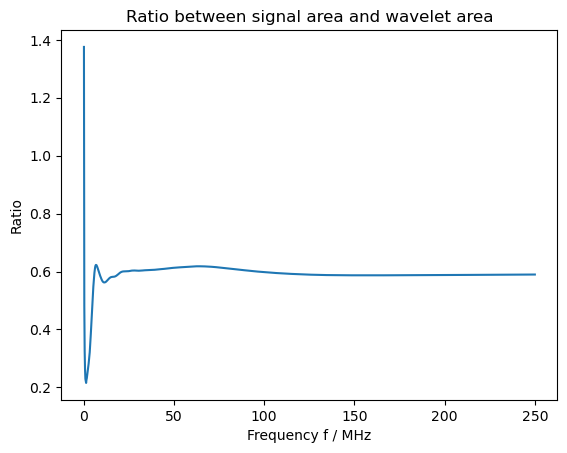

In [1446]:
plt.plot(Realpart(deconv["frequency"])[1:]/1E6,psum[1:]/wlsum[1:])
plt.title("Ratio between signal area and wavelet area")
plt.xlabel("Frequency f / MHz")
plt.ylabel("Ratio")

The maximum in the above diagram provides the smallest scaling factor and fulfills the requirement that the area under the signal spectrum must – compared to the wavelet – be smaller for all frequencies.

The maximum was found at 6.999999999999999 MHz and has a value of 0.6226511360214604.


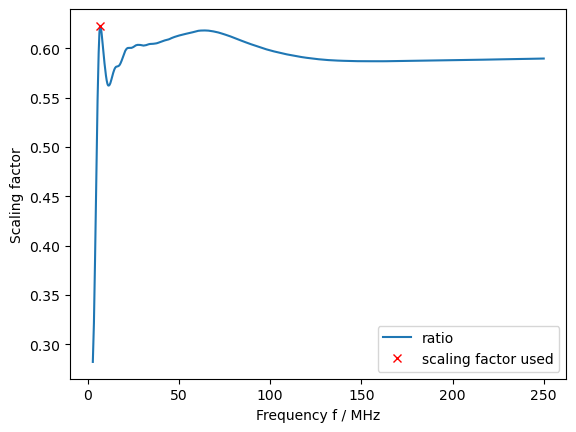

In [1447]:
plt.plot(Realpart(deconv["frequency"])[int(iffun/2):]/1e6,psum[int(iffun/2):]/wlsum[int(iffun/2):])
plt.xlabel("Frequency f / MHz")
plt.ylabel("Scaling factor")


daten = psum[int(iffun/2):]/wlsum[int(iffun/2):]
frequenz = Realpart(deconv["frequency"])[int(iffun/2):]
idxmax = np.argmax(daten)
print("The maximum was found at {0} MHz and has a value of {1}.".format(frequenz[idxmax]*1e-6,daten[idxmax]))
plt.plot(frequenz[idxmax]/1e6,daten[idxmax],"rx")
plt.legend(["ratio","scaling factor used"])
scaling = daten[idxmax]
if idxmax>frequenz.size-10:
    print("Warning: The maximum was found at the end of the data set. This might be an indicator of the fact that the signal contains too much noise. Please check manually for plausibility.")

### 6.2. Integration to estimate the total pressure
A symbolic integration of the previously described wavelet is carried out. The scaling factor is applied, as well as the frequency width. The wavelet is expressed as a pressure value. For calculation, the pressure per bandwidth ($\Delta f$) must be considered.

$p = \int_0^\infty \frac{wavelet(f)}{\Delta f}  \cdot scaling \cdot df$ 

Calculated total pressure sum: 9.91757315428435 MPa


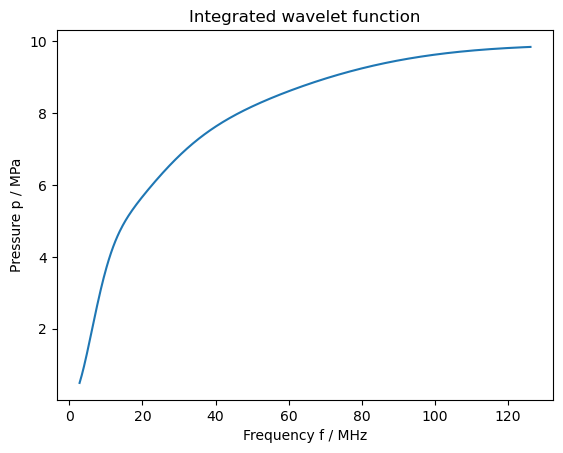

In [1448]:
integrand = fktw*scaling/deconv["frequency"][1]

integralfkt = sym.integrate(integrand,fsym)

tx3 = sym.lambdify(fsym,integralfkt)
temp3werte = np.array(list(map(tx3,Realpart(frequenz))))-tx3(0)
plt.plot(Realpart(frequenz)/1E6,temp3werte/1E6)
plt.title("Integrated wavelet function")
plt.xlabel("Frequency f / MHz")
plt.ylabel("Pressure p / MPa")

pges = sym.integrate(integrand,(fsym,0,sym.oo))
print("Calculated total pressure sum: {0} MPa".format(pges*1e-6))

In [1449]:
fifi = sym.re(sym.Abs(1-Hl))
wavletz = fktw*scaling/deconv["frequency"][1]
integrand = (fifi*wavletz)
fktlam = sym.lambdify(fsym,integrand)
deltapX = sp.integrate.quad(fktlam,0,1e15,points=[1e5,1e6,1e7,1e8,1e9,1e10])
deltap = deltapX[0]
print("Estimated uncertainty of the pressure: {0} MPa".format(deltap*1e-6))

Estimated uncertainty of the pressure: 0.2549264090778481 MPa


The uncertainty value is added to each point in the time series of the time domain signal as the uncertainty of the pressure.

In the following plot, the signal, the wavelet function and the scaled wavelet function are shown together.

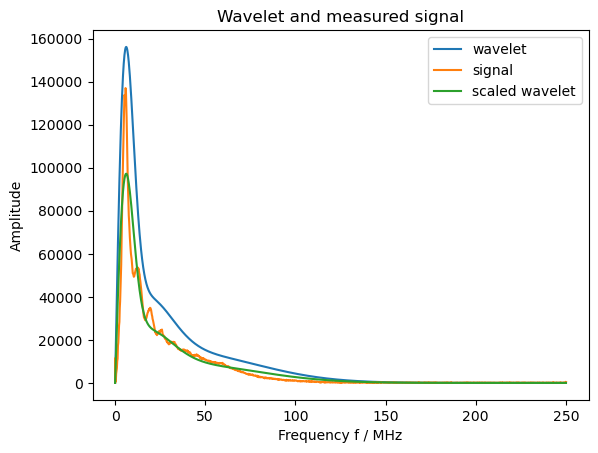

In [1450]:
plt.plot(Realpart(deconv["frequency"])/1E6,ytest3)
ytest4 = [xtemp*scaling for xtemp in ytest3]
plt.plot(Realpart(deconv["frequency"])/1E6,Amplitude(deconv["p"]))
plt.plot(Realpart(deconv["frequency"])/1E6,ytest4)
plt.title("Wavelet and measured signal");
plt.xlabel("Frequency f / MHz");
plt.ylabel("Amplitude");
plt.legend(["wavelet","signal","scaled wavelet"]);

## 7. *Optional test*: Plot of the hydrophone's filtered impulse response
Here, a short test is shown in order to visualize the frequency response of the hydrophone before and after applying the regularization filter.

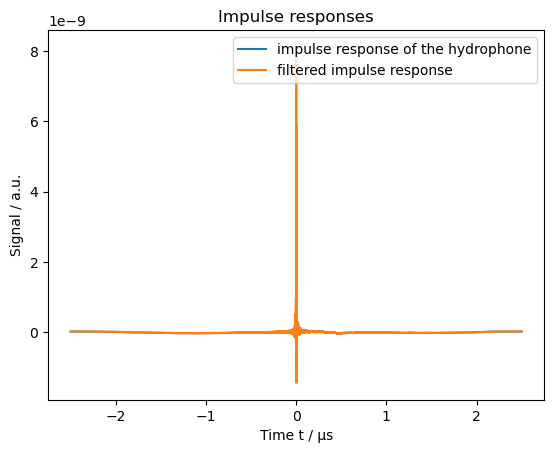

In [1451]:
x = np.append(hyd_interpolated["real"],hyd_interpolated["imag"])
a = np.hstack([np.diag(hyd_interpolated["varreal"]),np.diag(hyd_interpolated["kovar"])])
b = np.hstack([np.diag(hyd_interpolated["kovar"]),np.diag(hyd_interpolated["varimag"])])
ux = np.vstack([a,b])
[imp,uimp] = PyDynamic.GUM_iDFT(x,ux)
np.shape(ux)

dt = 1/(hyd_interpolated["frequency"][1]-hyd_interpolated["frequency"][0])
testtime = np.linspace(-dt/2,dt/2,np.size(imp)) #only for visualization, not for calculation, as no correction for the last data point is made!

[impfiltf,uimpfiltf] = PyDynamic.DFT_deconv(filt,x,0*ux,ux)
[impfilt,uimpfilt] = PyDynamic.GUM_iDFT(impfiltf,uimpfiltf)

plt.plot(testtime/1E-6,np.fft.fftshift(imp))
plt.plot(testtime/1E-6,np.fft.fftshift(impfilt))
plt.title("Impulse responses")
plt.legend(["impulse response of the hydrophone","filtered impulse response"]);
plt.xlabel("Time t / µs");
plt.ylabel("Signal / a.u.");

Text(0.5, 0, 'Frequency f / MHz')

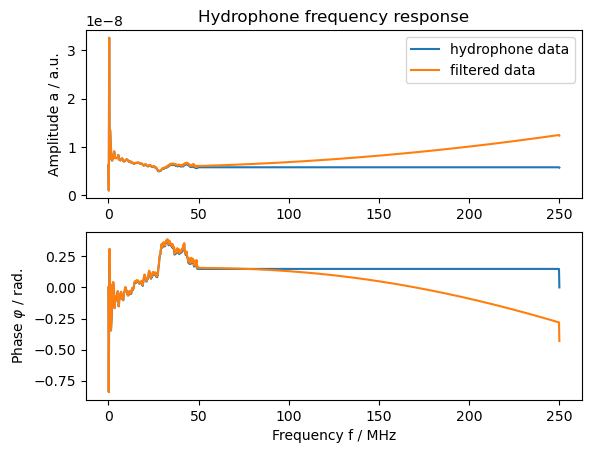

In [1452]:
plt.subplot(2,1,1)
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,Amplitude(np.append(hyd_interpolated["real"],hyd_interpolated["imag"])))
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,Amplitude(impfiltf))
plt.legend(["hydrophone data","filtered data"])
plt.ylabel("Amplitude a / a.u.")
plt.title("Hydrophone frequency response")
plt.subplot(2,1,2)
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,Phase(np.append(hyd_interpolated["real"],hyd_interpolated["imag"])))
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,Phase(impfiltf))
plt.ylabel(r"Phase $\varphi$ / rad.")
plt.xlabel("Frequency f / MHz")

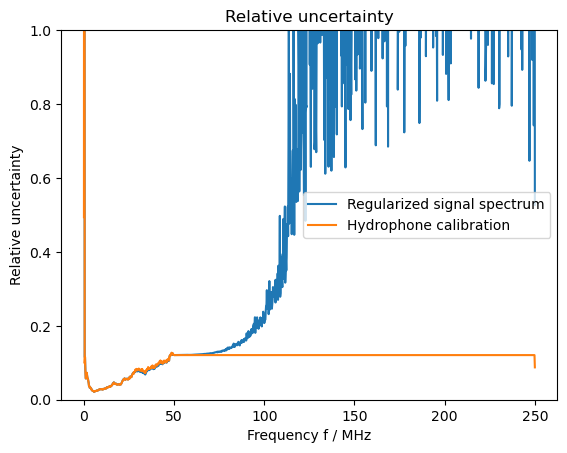

In [1453]:
plt.plot(Realpart(hyd_interpolated["frequency"][1:])/1E6,Amplitude(np.sqrt(np.diag(regul["Up"])))[1:]/Amplitude(regul["p"])[1:])
plt.plot(Realpart(hyd_interpolated["frequency"])/1E6,np.sqrt(hyd_interpolated["varreal"]+hyd_interpolated["varimag"])/(np.sqrt(hyd_interpolated["real"])**2 + hyd_interpolated["imag"]**2) )
plt.ylim(0,1)
plt.xlabel("Frequency f / MHz")
plt.ylabel("Relative uncertainty")
plt.title("Relative uncertainty")
plt.legend(["Regularized signal spectrum","Hydrophone calibration"])

## 8. Plot of the time domain signal
Now all calculations are finished and the final result is shown in the time domain. For comparison, the scaled signal using the hydrophone sensitivity at the acoustic work frequency, the deconvolved signal without additional filtering, and the deconvolved signal including regularization filtering are displayed.

In [1454]:
#Back transformation from the frequency domain into the time domain
(sigp,Usigp) = PyDynamic.GUM_iDFT(regul["p"],regul["Up"])
#Usigp is the covariance matrix resulting from the deconvolution
#Usigpexp is the covariance matrix expanded by the uncertainty contribution determined by the wavelet method
Usigpexp =  Usigp*(np.size(sigp)**2)/4+np.diag(np.ones_like(sigp))*deltap**2/3
deltasigp = np.sqrt( np.diag(Usigpexp))
sigp = sigp*np.size(sigp)/2
sigt = deconvtime["t"]

In [1455]:
print("Test for undoing the normation correctly")
print(2/np.size(measurement_data["time"])*np.size(sigp)/2)
print(4/(np.size(measurement_data["time"]))**2 * (np.size(sigp)**2/4))

Test for undoing the normation correctly
1.0
1.0


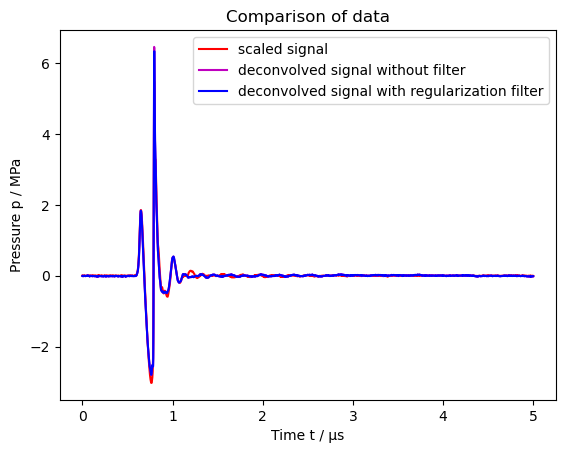

In [1456]:
# 1. plot of the scaled signal with hydrophone sensitivity at fundamental frequency
plt.plot(measurement_data["time"]/1e-6,measurement_data["voltage"]/hydempffun/1e6,"r")
plt.plot(deconvtime["t"]/1e-6,deconvtime["p"]/1e6,"m")
#2. plot of the deconvolved signal
plt.plot(sigt/1e-6,sigp/1e6,"b")
plt.legend(["scaled signal","deconvolved signal without filter","deconvolved signal with regularization filter"])
plt.title("Comparison of data");
plt.xlabel("Time t / µs");
plt.ylabel("Pressure p / MPa");

The next plot shows the deconvolved and regularized waveform, including the uncertainty for k = 2. For comparison, the uncertainty without the contribution from regularization filtering is also shown.

Text(0, 0.5, 'Pressure p / MPa')

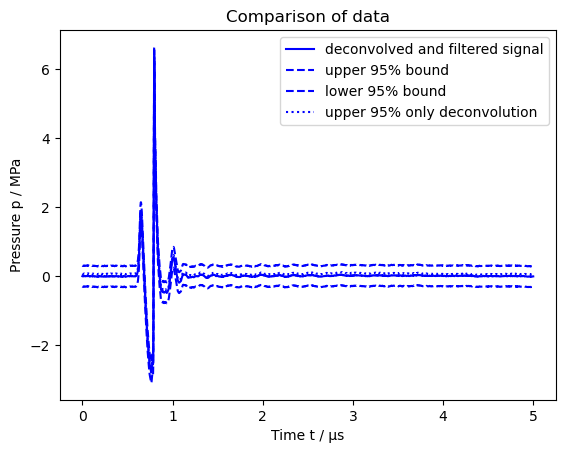

In [1457]:
plt.plot(sigt/1e-6,sigp/1e6,"b")
plt.plot(sigt/1e-6,(sigp+2*deltasigp)/1e6,"b--")
plt.plot(sigt/1e-6,(sigp-2*deltasigp)/1e6,"b--")
plt.plot(sigt/1e-6,(sigp+2*np.sqrt( np.diag(Usigp)*np.size(sigp)**2/4))/1e6,"b:")
plt.legend(["deconvolved and filtered signal","upper 95% bound","lower 95% bound","upper 95% only deconvolution"])
plt.title("Comparison of data")
plt.xlabel("Time t / µs")
plt.ylabel("Pressure p / MPa")

In [1458]:
pulseparameters = pulseparameter(sigt,sigp,Usigpexp)

In [1459]:
k = 1
print("peak compressional pressure pc = ({0:.3f} ± {1:.3f}) MPa at {2:.3f} µs ({3:.3f}%) for k = {4:.1f}".format(pulseparameters["pc_value"]/1e6,k*pulseparameters["pc_uncertainty"]/1E6,pulseparameters["pc_time"]*1E6,k*100*pulseparameters["pc_uncertainty"]/pulseparameters["pc_value"],k))
print("peak rarefactional pressure pr = ({0:.3f} ± {1:.3f}) MPa at {2:.3f} µs ({3:.3f}%) for k = {4:.1f}".format(pulseparameters["pr_value"]/1e6,k*pulseparameters["pr_uncertainty"]/1E6,pulseparameters["pr_time"]*1E6,k*100*pulseparameters["pr_uncertainty"]/pulseparameters["pr_value"],k))
print("pulse-pressure-squared integral ppsi = ({0:.3f} ± {1:.3f}) kPa^2 s ({2:.3f}%) for k = {3:.1f} ".format(pulseparameters["ppsi_value"]/1e6,k*pulseparameters["ppsi_uncertainty"]/1e6,k*100*pulseparameters["ppsi_uncertainty"]/pulseparameters["ppsi_value"],k))

peak compressional pressure pc = (6.341 ± 0.151) MPa at 0.798 µs (2.388%) for k = 1.0
peak rarefactional pressure pr = (2.798 ± 0.151) MPa at 0.764 µs (5.410%) for k = 1.0
pulse-pressure-squared integral ppsi = (1.141 ± 0.033) kPa^2 s (2.873%) for k = 1.0 


## 9. Export of data
In this step, the data is exported into a text file so that it can be further investigated and compared with other data sets. For later reference, the parameters used for the deconvolution are also stored in the file.

In [1460]:
resultname = infos["resultpathname"]+infos["measurementtype"].replace(" ", "")+\
            "_"+infos["hydrophonename"].replace(" ", "")+("_Bode" if infos.get("PhaseByBode",False) else "")+\
            "_"+infos["filter"].replace(" ", "")+("{0:.0f}MHz".format((infos["filter_fmax"]/1E6)) if (infos["filter"] != "None") else "")+".dat"
print(resultname)

Results/M-Mode6MHz_ONDA1704_LowPass150MHz.dat


In [1461]:
header = "time;scaled;deconvolved;regularized;uncertainty(k=1)"
footer = str(infos) + " Pulseparameters:" + str(pulseparameters)
data = np.transpose( [measurement_data["time"],measurement_data["voltage"]/hydempffun,deconvtime["p"],sigp,deltasigp])
np.savetxt(resultname,data,header = header,delimiter =";",footer=footer)

## 10. Additional comments
### 10.1. A note about Gibbs ringing
Due to the usage of the discrete Fourier transformation, the Fourier series are limited by upper frequencies. This may cause  artificial oscillations which become visible in the signal close to places with a high slope rate. Such oscillations have the same frequency as the Nyquist frequency. (They can easily be identified as a zigzag between the sampling points.) To minimize this effect, the cut-off frequency and the filter role-off (filter type) of the regularization filter may be adjusted.
### 10.2. Information about the system

In [1462]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
print("PyDynamic version")
print(PyDynamic.__version__)

Python version
3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)
PyDynamic version
2.4.2


## 11. Stored reference waveforms for comparison
To enable a comparison of the waveforms obtained by deconvolution using this tutorial with the results of other implementations, a set of results was stored for reference in the `results` folder. The parameters used for these evaluations are summed up in the table below. The last three columns show the waveform parameters obtained and copied here from the "individual results" data files. The uncertainties of the pulse parameters are for k = 1. They include the – often conservative – estimation of the contribution from regularization, cf. chapter 6.1, which could be optimized using advanced upper bound estimates. Other underlying assumptions were uncorrelated calibration data in the frequency domain and constant uncertainties of the extrapolated calibration data, cf. chapter 2.7.4.  

|Number (i)|Mode|Frequency|Hydrophone|Calibration range|ampl. cal. only|Bode eq.|filter type|cut-off fc|pc/MPa|pr/MPa|ppsi/(kPa^2 s)|
|------|----|---------|----------|----------------|-------------------|-----------------|----------|-----------------|----------|----------|-------------|
|1|M|3 MHz|GAMPT MH44|1 MHz to 60 MHz|yes|yes|low-pass|100 MHz|5.62 ± 0.12|2.63 ± 0.12|1.637 ± 0.016|
|2|M|3 MHz|GAMPT MH46|1 MHz to 100 MHz|yes|yes|low-pass|100 MHz|5.02 ± 0.13|2.51 ± 0.13|1.572 ± 0.016|
|3|M|3 MHz|ONDA 1704|0.1 MHz to 50 MHz|no|no|low-pass|100 MHz|5.30 ± 0.10|2.57 ± 0.10|1.600 ± 0.060|
|4|M|3 MHz|PA 1434|1 MHz to 50 MHz|yes|yes|low-pass|100 MHz|5.33 ± 0.11|2.54 ± 0.11|1.639 ± 0.025|
|5|pD|3 MHz|GAMPT MH44|1 MHz to 60 MHz|yes|yes|low-pass|120 MHz|3.38 ± 0.08|1.10 ± 0.08|2.618 ± 0.017|
|6|pD|3 MHz|GAMPT MH46|1 MHz to 100 MHz|yes|yes|low-pass|120 MHz|3.23 ± 0.08|1.05 ± 0.08|2.546 ± 0.015|
|7|pD|3 MHz|ONDA 1704|0.1 MHz to 50 MHz|no|no|low-pass|120 MHz|3.09 ± 0.07|1.06 ± 0.07|2.342 ± 0.020|
|8|pD|3 MHz|PA 1434|1 MHz to 50 MHz|yes|yes|low-pass|120 MHz|3.26 ± 0.08|1.22 ± 0.08|2.799 ± 0.024|
|9|M|6 MHz|GAMPT MH44|1 MHz to 60 MHz|yes|yes|low-pass|150 MHz|7.29 ± 0.16|2.86 ± 0.16|1.240 ± 0.016|
|10|M|6 MHz|GAMPT MH46|1 MHz to 100 MHz|yes|yes|low-pass|150 MHz|7.21 ± 0.18|2.74 ± 0.18|1.186 ± 0.018|
|11|M|6 MHz|ONDA 1704|0.1 MHz to 50 MHz|no|no|low-pass|150 MHz|6.34 ± 0.15|2.80 ± 0.15|1.141 ± 0.033|
|12|M|6 MHz|PA 1434|1 MHz to 50 MHz|yes|yes|low-pass|150 MHz|6.29 ± 0.18|2.83 ± 0.18|1.188 ± 0.018|
|13|pD|7 MHz|GAMPT MH44|1 MHz to 60 MHz|yes|yes|low-pass|200 MHz|5.67 ± 0.20|1.49 ± 0.20|3.176 ± 0.034|
|14|pD|7 MHz|GAMPT MH46|1 MHz to 100 MHz|yes|yes|low-pass|200 MHz|6.24 ± 0.19|1.44 ± 0.19|3.141 ± 0.033|
|15|pD|7 MHz|ONDA 1704|0.1 MHz to 50 MHz|no|no|low-pass|200 MHz|4.88 ± 0.09|1.46 ± 0.09|2.899 ± 0.097|
|16|pD|7 MHz|PA 1434|1 MHz to 50 MHz|yes|yes|low-pass|200 MHz|5.21 ± 0.17|1.44 ± 0.17|3.114 ± 0.034|


# Literature
<a id="literature"></a>

[Achenbach1988] Johann-Jost Achenbach: **System-Synthese Grundlagen der Synthesemethoden kontinuierlicher und diskreter Systeme und Filter für die Praxis**, 1988, VDI Verlag Düsseldorf

[Bechhoefer2011] John Bechhoefer: **Kramers–Kronig, Bode, and the meaning of zero**, American Journal of Physics Vol. 79 10, 2011, DOI: [10.1119/1.3614039](http://dx.doi.org/10.1119/1.3614039)

[Bloomfield2014] Philip E. Bloomfield and Peter A. Lewin: **Determination of Ultrasound Hydrophone Phase from Fourier-Hilbert Transformed 1 to 40 MHz Time Delay Spectrometry Amplitude**, IEEE Transactions on Ultrasonics, Ferroelectrics and Frequency Control Vol. 61 4, 2014, DOI: [10.1109/TUFFC.2014.2954](http://dx.doi.org/10.1109/TUFFC.2014.2954)

[Cooling2008] Martin P. Cooling and Victor F. Humphrey: **A nonlinear propagation model-based phase calibration technique for membrane hydrophones**, IEEE Transactions on Ultrasonics, Ferroelectrics and Frequency Control Vol. 55, No. 1, 2008, DOI: [10.1109/TUFFC.2008.619](http://dx.doi.org/10.1109/TUFFC.2008.619)

[Eichstaedt2016a] S. Eichstädt, V. Wilkens, A. Dienstfrey, P. Hale, B. Hughes and C. Jarvis: **On challenges in the uncertainty evaluation for time-dependent measurements**, Metrologia Vol. 53 S125-S135, 2016, DOI: [10.1088/0026-1394/53/4/S125](http://dx.doi.org/10.1088/0026-1394/53/4/S125)

[Eichstädt2016b] Sascha Eichstädt and Volker Wilkens: **GUM2DFT—a software tool for uncertainty evaluation of transient signals in the frequency domain**, Measurement Science and Technology Vol. 27 055001, 2016, DOI: [10.1088/0957-0233/27/5/055001](https://doi.org/10.1088/0957-0233/27/5/055001)

[Eichstaedt2017] Sascha Eichstädt and Volker Wilkens: **Evaluation of uncertainty for regularized deconvolution: A case study in hydrophone measurements**, The Journal of the Acoustical Society of America, 2017, DOI: [10.1121/1.4983827](http://dx.doi.org/10.1121/1.4983827)

[GUM2008] Working Group 1 of the Joint Committee for Guides in Metrology: **Evaluation of measurement data — Guide to the expression of uncertainty in measurement**, 2008, BIPM, [PDF](https://www.bipm.org/utils/common/documents/jcgm/JCGM_100_2008_E.pdf) (last access 11.12.2019)

[Hurrell2016] Andrew Hurrell and Srinath Rajagopal: **The practicalities of obtaining and using hydrophone calibration data to derive pressure waveforms**, IEEE Transactions on Ultrasonics, Ferroelectrics and Frequency Control Vol. 64, No. 1, 2017 DOI: [10.1109/TUFFC.2016.2594770](http://dx.doi.org/10.1109/TUFFC.2016.2594770)

[PTB2014] Wolfgang Schmid: **Korrelation bei Messunsicherheitsanalysen**, 277. PTB-Seminar: Berechnung der Messunsicherheit - Empfehlungen für die Praxis, Berlin, 11. und 12. März 2014 [PDF](https://www.ptb.de/cms/fileadmin/internet/fachabteilungen/abteilung_8/8.4_mathematische_modellierung/277_PTB_SEMINAR/VORTRAEGE/05_Schmid-Korrelationen.pdf) (last access 10.03.2020)

[PTB2017] **PTB Mitteilungen 4/2017**, 127. Jahrgang, Heft 4, Dezember 2017, Publisher: Physikalisch-Technische Bundesanstalt, Braunschweig [PTB Mitteilungen 4/2017](https://www.ptb.de/cms/fileadmin/internet/publikationen/ptb_mitteilungen/mitt2017/Heft4/PTB-Mitteilungen_2017_Heft_4.pdf)

[PyDynamic] Björn Ludwig, Sascha Eichstädt, et al.: **PyDynamic - Python package for the analysis of dynamic measurements**, Online resource, DOI: [10.5281/zenodo.3835495](https://doi.org/10.5281/zenodo.3835495)

[Wear2014] Keith A. Wear, Paul M. Gammell, Subha Maruvada, Yunbo Liu and G. R. Harris: **Improved measurement of acoustic output using complex deconvolution of hydrophone sensitivity**, IEEE Transactions on Ultrasonics, Ferroelectrics and Frequency Control Vol. 61, No. 1, 2014, DOI: [10.1109/TUFFC.2014.2879](http://dx.doi.org/10.1109/TUFFC.2014.2879)

[Weber2017] Martin Weber and Volker Wilkens: **Using a heterodyne vibrometer in combination with pulse excitation for primary calibration of ultrasonic hydrophones in amplitude and phase**, Metrologia Vol. 54, No. 4, 2017, DOI: [10.1088/1681-7575/aa72ba](http://dx.doi.org/10.1088/1681-7575/aa72ba)

[White2017] White, D.R.: **Propagation of Uncertainty and Comparison of Interpolation Schemes**, Int J Thermophys  38: 39, 2017, DOI: [10.1007/s10765-016-2174-6](https://dx.doi.org/10.1007/s10765-016-2174-6)

[Wilkens2004] Volker Wilkens and Christian Koch: **Amplitude and phase calibration of hydrophones up to 70 MHz using broadband pulse excitation and an optical reference hydrophone**, J. Acoust. Soc. Am. Vol. 115, No. 6, 2004, DOI: [10.1121/1.1707087](http://dx.doi.org/10.1121/1.1707087)

[Wilkens2016] Volker Wilkens, Sven Sonntag and Olga Georg: **Robust spot-poled membrane hydrophone for measurement of large amplitude pressure waveforms generated by high intensity therapeutic ultrasound transducers**, J. Acoust. Soc. Am. Vol. 139, No. 3, 2016, DOI: [10.1121/1.4944693](http://dx.doi.org/10.1121/1.4944693)

[Wilkens2019] Volker Wilkens, Sven Sonntag and Martin Weber: **Secondary complex-valued hydrophone calibration up to 100 MHz using broadband pulse excitation and a reference membrane hydrophone**, In: Proceedings of the 2019 IEEE International Ultrasonics Symposium (IUS), Glasgow Scotland, October 6-9, 2019, WeH5.2